In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import re
import warnings
import random
import matplotlib
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from scipy.stats import linregress, spearmanr
import analysis_utils
from copy import deepcopy
import importlib

# path to repository folder (data is stored here as well)
path = '..'
preds_loc = os.path.join(path, 'data', 'inference', 'Ssym_mapped_preds_clusters.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

In [2]:
ssymp = pd.read_csv(os.path.join(path, 'data', 'external_datasets', 'Ssym+_experimental.csv'))
ssymp['uid'] = ssymp['Protein'].str[:4].apply(lambda x: x.upper())  + '_' + ssymp['Mut_pdb'].str[1:]
ssymp = ssymp.set_index('uid')

In [3]:
### load and preprocess data

# load main data
db = pd.read_csv(preds_loc, index_col=0)

db = db.reset_index()
db['uid2'] = db['code'] + '_' + db['position'].astype(int).astype(str) + db['mutation'].str[-1]
db = db.set_index(['uid', 'uid2'])

for code in db['wt_code'].unique():
    cluster = db.loc[db['code']==code, 'cluster'].head(1).item()
    db.loc[db['wt_code']==code, 'cluster'] = cluster

db['direction'] = 'dir'
db.loc[db['code']!=db['wt_code'], 'direction'] = 'inv'

for col in ['KORPM', 'Cartddg', 'FoldX', 'Evo', 'Dyna2', 'PopMs', 'DDGun', 'TNet', 'ACDCNN', 'ddG']:
    db = db.rename({col: col + '_dir'}, axis=1)

# extract prediction columns
incl = [col for col in db.columns if '_dir' in col and not 'runtime' in col]
# get only unique mutations (predictions are always the same)
db_preds = db[incl].drop_duplicates()
#print(db_preds.head())
#db_ddg = db[['ddG_dir']]
db_clusters = db[['cluster']]
db_direction = db[['direction']]
db_ddgs = db[['ddG_dir']]

# extract runtimes for each prediction type
db_runtimes = db[[col for col in db.columns if 'runtime' in col] + ['code']].drop_duplicates()
# estimate the per-mutation runtime (the code takes about 6 seconds to run 6313 mutations)
db_runtimes['runtime_korpm_dir'] = 0.0015

# reassign the Tranception runtimes to be per-mutation (by dividing by the number of mutations)
for col in [c for c in db_runtimes.columns if 'tranception' in c]:
    grouped = db_runtimes.groupby('code')[col]
    mean_values = grouped.mean()
    group_sizes = grouped.size()

    # Divide mean values by group sizes
    divided_values = mean_values / group_sizes
    # Merge the divided_values back to the original DataFrame
    db_runtimes = db_runtimes.merge(divided_values.rename('divided_value'), left_on='code', right_index=True)
    # Reassign the 'target_column' values with the divided values
    db_runtimes[col] = db_runtimes['divided_value']
    # Drop the 'divided_value' column
    db_runtimes = db_runtimes.drop('divided_value', axis=1)

# ~15 seconds

In [4]:
original_pred_cols = [c for c in db.columns if '_dir' in c and not 'runtime' in c and not 'pll' in c and not 'ddG' in c]
db_preds = db[original_pred_cols]

original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
#for col in ['esm2_15B_half_dir', 'esm2_150M_dir']:
#    original_pred_cols_reduced.remove(col)

db_preds

,,esmif_monomer_dir,ACDCNN_dir,Cartddg_dir,DDGun_dir,Dyna2_dir,Evo_dir,FoldX_dir,KORPM_dir,PopMs_dir,TNet_dir,...,esm1v_2_dir,esm1v_3_dir,esm1v_4_dir,esm1v_5_dir,esm1v_median_dir,esm1v_mean_dir,ankh_dir,korpm_dir,mutcomputex_dir,stability-oracle_dir
uid,uid2,,,,,,,,,,,,,,,,,,,,,
107L_44S,107L_44S,0.016577,-0.131,1.69,0.072,-0.581,0.70,0.57,0.427,0.13,0.01,...,0.800201,0.605376,0.510154,1.220110,0.605376,0.642675,4.276441,0.544,-0.999986,0.438
108L_44S,108L_44S,-0.009064,-0.334,-1.73,-0.106,-0.295,-1.46,-0.47,0.159,0.39,-0.40,...,0.492721,0.396152,0.220262,0.268132,0.268132,0.240539,1.753344,0.194,-0.034210,-0.105
109L_44S,109L_44S,-0.005914,-0.175,-0.98,0.009,-0.340,0.06,-0.62,-0.051,-0.26,-0.01,...,-0.860153,0.054036,-0.641212,-0.931148,-0.641212,-0.566803,2.483467,-0.079,-0.406980,-0.375
110L_44S,110L_44S,0.005226,-0.157,-1.26,-0.099,-0.213,-1.34,-0.65,0.087,0.21,-0.40,...,0.503650,0.549975,0.508147,0.413473,0.503650,0.466007,2.295459,0.108,-0.089660,-0.103
111L_44S,111L_44S,0.003130,-0.028,-0.24,0.000,0.218,-0.15,-0.61,0.127,-0.02,-0.09,...,0.433894,0.670423,0.394354,0.552454,0.433894,0.483406,2.562860,0.170,0.012168,0.197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5PTI_23A,5PTI_23A,-0.199087,-3.108,-8.00,-3.658,-3.856,-3.57,-1.42,-2.601,-1.03,-2.63,...,-8.460078,-8.768191,-8.526881,-8.345311,-8.460078,-8.293155,-11.227180,-3.278,-0.861620,-2.782
5PTI_35G,5PTI_35G,-0.296928,-3.816,-8.00,-3.980,-3.944,-4.04,-3.03,-2.470,0.22,-1.77,...,-7.625252,-7.928805,-9.172729,-7.315306,-7.928805,-8.104215,-8.834322,-3.128,-0.531967,-3.854
5PTI_43G,5PTI_43G,-0.301580,-1.786,-8.00,-1.756,-3.047,-3.00,-2.02,-1.219,-0.15,-0.58,...,-6.248067,-6.697584,-5.424959,-8.513042,-6.697584,-6.862028,-8.326775,-1.552,-0.957911,-1.180


In [5]:
df_cart, df_cart_runtimes = analysis_utils.parse_rosetta_predictions(db.reset_index('uid', drop=True).reset_index().rename({'uid2': 'uid'}, axis=1).set_index('uid'), os.path.join(path, 'data', 'rosetta_predictions'), runtime=True)
db_preds = db_preds.reset_index().rename({'uid': 'uid_', 'uid2': 'uid'}, axis=1).set_index('uid').join(df_cart.astype(float).rename_axis('uid'), how='left')
db_preds = db_preds.reset_index(drop=True).rename({'uid_': 'uid'}, axis=1).set_index('uid')
db_runtimes = db_runtimes.reset_index('uid').join(df_cart_runtimes.astype(float), how='left')

In [6]:
#db_complete = db.copy(deep=True)
#db_complete = pd.read_csv(preds_loc, index_col=0)

# load effective number of sequences from separate file (generated by MSA transformer)
neff = pd.read_csv(os.path.join(path, 'data', 'features', 'neff_ssym.csv'), header=None).set_index(0)
neff.index.name = 'code'
neff.columns = ['neff', 'sequence_length']
neff = neff.groupby(level=0).max()

db_feats_2 = pd.read_csv(os.path.join(path, 'data', 'features', 'Ssym_local_mapped_feats.csv'))
db_feats_2['uid'] = db_feats_2['code'] + '_' + db_feats_2['position_orig'].astype(str) + db_feats_2['mutation']
db_feats_2['uid2'] = db_feats_2['code'] + '_' + db_feats_2['position'].astype(str) + db_feats_2['mutation']

db_feats_2 = db_feats_2.set_index('uid')
db_feats_2 = db_feats_2[['uid2', 'on_interface', 'entropy', 'conservation', 'column_completeness', 'completeness_score', 'n_seqs', 'structure_length', 'SS', 'position_orig',
                        'features', 'hbonds', 'saltbrs', 'b_factor', 'kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'rel_ASA', 'wt_code', 'code', 'position', 'wild_type', 'mutation']] #'residue_depth',

db_feats_2['on_interface'] = db_feats_2['on_interface'].astype(int)
db_feats_2['features'] = db_feats_2['features'].fillna("")#.apply(list)
#db_complete = db_complete.join(db_feats_2.set_index('uid'))#.drop('uid2', axis=1).set_index('uid')
db_feats_2['delta_kdh'] = db_feats_2['kdh_mut'] - db_feats_2['kdh_wt']
db_feats_2['delta_vol'] = db_feats_2['vol_mut'] - db_feats_2['vol_wt']
db_feats_2['delta_chg'] = db_feats_2['chg_mut'] - db_feats_2['chg_wt']
#db_feats_2['delta_asa'] = db_feats_2['SOL_ACC_inv'] - db_feats_2['SOL_ACC_dir']
db_feats_2['to_proline'] = (db_feats_2.index.str[-1] == 'P').astype(int)
db_feats_2['to_glycine'] = (db_feats_2.index.str[-1] == 'G').astype(int)
db_feats_2['from_proline'] = (db_feats_2.index.str[6] == 'P').astype(int)
db_feats_2['from_glycine'] = (db_feats_2.index.str[6] == 'G').astype(int)
db_feats_2['helix'] = db_feats_2['SS'] == 'H'
db_feats_2['bend'] = db_feats_2['SS'] == 'S'
db_feats_2['turn'] = db_feats_2['SS'] == 'T'
db_feats_2['coil'] = db_feats_2['SS'] == '-'
db_feats_2['strand'] = db_feats_2['SS'] == 'E'
#db_feats_2['xray_else_NMR'] = db_feats_2['nmr_xray'].str.contains('X-RAY')
db_feats_2['active_site'] = db_feats_2['features'].str.contains('ACT_SITE')
#db_feats_2['resolution'] = db_feats_2['resolution'].fillna('').apply(lambda x: analysis_utils.extract_decimal_number(x))
#db_feats_2['mpnn_median_dir'] = db_feats_2[['mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir']].mean(axis=1)
db_feats_2 = db_feats_2.drop(['kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'features', 'SS'], axis=1)
# 'mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir', 'mpnn_10_dir', 'mpnn_30_dir', 'mpnn_30_03_dir', 'mpnn_20_02_dir',
db_feats_2 = db_feats_2.reset_index().merge(neff['neff'].dropna(), on='code', how='left')#.drop('code', axis=1)#.set_index('uid')
db_feats_2['neff'] = db_feats_2['neff'].fillna(0)
unique_indices = db_feats_2.groupby('uid')['neff'].idxmax()#.astype(int)
db_feats_2 = db_feats_2.loc[unique_indices].set_index(['uid', 'uid2'])

#db_complete['random_dir'] = np.random.rand(len(db_complete)) - 0.5

for feature in ['on_interface', 'features', 'rel_ASA', 'delta_kdh', 'delta_vol', 'delta_chg', 'to_proline', 'to_glycine', 'from_proline', 'from_glycine', 'helix', 'bend', 'turn', 'coil', 'strand', 'active_site']:
    db_feats_2 = db_feats_2.rename({feature: feature + '_dir'}, axis=1)

db_feats_2

,,on_interface_dir,entropy,conservation,column_completeness,completeness_score,n_seqs,structure_length,position_orig,hbonds,saltbrs,...,to_glycine_dir,from_proline_dir,from_glycine_dir,helix_dir,bend_dir,turn_dir,coil_dir,strand_dir,active_site_dir,neff
uid,uid2,,,,,,,,,,,,,,,,,,,,,
107L_44S,107L_44S,0,1.350482,4.048295,0.308949,0.850995,1408.0,162,44,2,0,...,0,0,0,True,False,False,False,False,False,0.000000
108L_44S,108L_44S,0,1.350482,0.355114,0.308949,0.850995,1408.0,162,44,2,0,...,0,0,0,True,False,False,False,False,False,0.000000
109L_44S,109L_44S,0,1.350482,3.764205,0.308949,0.850995,1408.0,162,44,2,0,...,0,0,0,True,False,False,False,False,False,0.000000
110L_44S,110L_44S,0,1.350482,0.994318,0.308949,0.850995,1408.0,162,44,2,0,...,0,0,0,True,False,False,False,False,False,0.000000
111L_44S,111L_44S,0,1.350482,5.113636,0.308949,0.850995,1408.0,162,44,2,0,...,0,0,0,True,False,False,False,False,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5PTI_23A,5PTI_23A,0,0.778851,63.758389,0.999484,0.823609,1937.0,58,23,2,0,...,0,0,0,False,False,False,False,True,False,1516.376889
5PTI_35G,5PTI_35G,0,1.059996,74.909654,0.993289,0.823609,1937.0,58,35,2,0,...,1,0,0,False,False,False,False,True,False,1516.376889
5PTI_43G,5PTI_43G,0,0.222989,96.644295,0.999484,0.823609,1937.0,58,43,4,0,...,1,0,0,False,True,False,False,False,False,1516.376889


In [7]:
df = db_preds.join(db_feats_2[['delta_kdh_dir', 'delta_vol_dir', 'rel_ASA_dir', 'wt_code', 'wild_type', 'position_orig', 'mutation']]).join(db_ddgs).join(db_runtimes).reset_index('uid2')

df['code'] = df.index.str[:4]
db1 = df.loc[df['code'].str[:4]==df['wt_code']]
print(len(db1))
db1 = db1.drop(['code', 'wt_code'], axis=1)
#db1.columns = [c + '_dir' for c in db1.columns]
db2 = df.loc[df['code'].str[:4]!=df['wt_code']]
db2['uid'] = db2['wt_code'] + '_' + db2['position_orig'].astype(str) + db2['wild_type']
db2 = db2.set_index('uid')
print(len(db2))
db2 = db2.drop(['code', 'wt_code'], axis=1)
db2.columns = [c.replace('_dir', '_inv') for c in db2.columns]
db2 = db2[[c for c in db2.columns if '_inv' in c]]
db_flat = db1.join(db2)
db_flat

# sequence methods are necessarily antisymmetric. This fills in missing or erroneous values
for col in db_flat.columns:
    if '_dir' in col:
        if any([e in col for e in ['esm2', 'esm1v', 'msa', 'tranception', 'ankh']]) and not 'runtime' in col:
            db_flat[col.replace('_dir', '_inv')] = -db_flat[col]

db_ddgs_2 = db_flat[['ddG_dir', 'ddG_inv']]
db_flat

test = db_flat.join(ssymp, lsuffix='_plus').drop('uid2', axis=1)
float_columns = test.select_dtypes(include=['float']).columns
db_class = test[float_columns]
db_class.columns = ['plus_' + c[:-5] if 'plus' in c else c for c in db_class.columns]
db_class = db_class.drop([c+'_dir' for c in ['ACDCNN', 'ACDC-NN-2str', 'plus_FoldX', 'plus_DDGun', 'PopMs', 'TNet', 'Dyna2']], axis=1)
db_class = db_class.drop([c+'_inv' for c in ['ACDCNN', 'ACDC-NN-2str', 'plus_FoldX', 'plus_DDGun', 'PopMs', 'TNet', 'Dyna2']], axis=1)

db_stacked = analysis_utils.stack_frames(db_class)
db_stacked_preds = db_stacked[[c for c in db_stacked.columns if not 'runtime' in c]]
db_stacked_runtimes = db_stacked[[c for c in db_stacked.columns if 'runtime' in c]]
db_stacked_runtimes

342
342


pred_col             runtime_ankh  runtime_cartesian_ddg  runtime_esm1v_1  \
direction uid                                                               
dir       1AMQ_191F      0.182606                    6.0         0.067344   
          1AMQ_191S      0.181212                    8.0         0.066351   
          1AMQ_191W      0.180855                    8.0         0.066890   
          1AMQ_191Y      0.180631                    7.0         0.067232   
          1BNI_14A       0.107334                    6.0         0.034200   
...                           ...                    ...              ...   
inv       5PTI_22A       0.112357                    5.0         0.030202   
          5PTI_23A       0.106133                    7.0         0.030067   
          5PTI_35G       0.105802                   11.0         0.030636   
          5PTI_43G       0.105657                   11.0         0.030900   
          5PTI_45A       0.095485                   66.0         0.032464   

pred_col             runtime_esm1v_2  runtime_esm1v_3  runtime_esm1v_4  \
direction uid                                                            
dir       1AMQ_191F         0.066230         0.066228         0.066444   
          1AMQ_191S         0.066204         0.066053         0.066372   
          1AMQ_191W         0.066931         0.066286         0.071942   
          1AMQ_191Y         0.066729         0.066720         0.066427   
          1BNI_14A          0.031118         0.030738         0.030340   
...                              ...              ...              ...   
inv       5PTI_22A          0.028447         0.029896         0.029325   
          5PTI_23A          0.028884         0.030771         0.032039   
          5PTI_35G          0.031073         0.030899         0.031054   
          5PTI_43G          0.028669         0.031164         0.030806   
          5PTI_45A          0.027214         0.030750         0.029823   

pred_col             runtime_esm1v_5  runtime_esm1v_mean  \
direction uid                                              
dir       1AMQ_191F         0.065980            0.332226   
          1AMQ_191S         0.066340            0.331320   
          1AMQ_191W         0.066381            0.338431   
          1AMQ_191Y         0.066803            0.333911   
          1BNI_14A          0.031391            0.157787   
...                              ...                 ...   
inv       5PTI_22A          0.031306            0.149177   
          5PTI_23A          0.030846            0.152607   
          5PTI_35G          0.029357            0.153019   
          5PTI_43G          0.030116            0.151654   
          5PTI_45A          0.026830            0.147081   

pred_col             runtime_esm1v_median  runtime_esm2  ...  \
direction uid                                            ...   
dir       1AMQ_191F              0.332226      0.185272  ...   
          1AMQ_191S              0.331320      0.184729  ...   
          1AMQ_191W              0.338431      0.184060  ...   
          1AMQ_191Y              0.333911      0.184031  ...   
          1BNI_14A               0.157787      0.070894  ...   
...                                   ...           ...  ...   
inv       5PTI_22A               0.149177      0.060836  ...   
          5PTI_23A               0.152607      0.061388  ...   
          5PTI_35G               0.153019      0.060102  ...   
          5PTI_43G               0.151654      0.060871  ...   
          5PTI_45A               0.147081      0.060835  ...   

pred_col             runtime_mpnn_20_00  runtime_mpnn_30_00  runtime_msa_1  \
direction uid                                                                
dir       1AMQ_191F            0.016232            0.016989       3.390493   
          1AMQ_191S            0.014761            0.016065       3.393482   
          1AMQ_191W            0.014751            0.016062       3.393750   
          1AMQ_191Y            

Original unique mutations: 684
['ACDC-NN', 'ACDC-NN-Seq', 'Cartddg', 'DDG', 'DDGun', 'DDGun3D', 'DUET', 'Dynamut', 'Dynamut2', 'Evo', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq', 'INPS-Seq', 'INPS3D', 'KORPM', 'MAESTRO', 'MUpro', 'PoPMuSiC', 'PremPS', 'SAAFEC-SEQ', 'SDM', 'ThermoNet', 'ankh', 'cartesian_ddg', 'delta_kdh', 'delta_vol', 'esm1v_mean', 'esm1v_median', 'esm2', 'esm2_150M', 'esm2_15B_half', 'esm2_650M', 'esmif_monomer', 'esmif_multimer', 'korpm', 'mCSM', 'mif', 'mifst', 'mpnn_10_00', 'mpnn_20_00', 'mpnn_30_00', 'msa_transformer_mean', 'msa_transformer_median', 'mutcomputex', 'rel_ASA', 'stability-oracle', 'tranception']
direction  uid      
dir        1AMQ_191F    4
inv        1AMQ_191F    4
dir        1AMQ_191S    4
inv        1AMQ_191S    4
dir        1AMQ_191W    4
                       ..
inv        5PTI_35G     9
dir        5PTI_43G     9
inv        5PTI_43G     9
dir        5PTI_45A     9
inv        5PTI_45A     9
Name: cluster, Length: 684, dtype: int64
cluster
1      

,,ACDC-NN,ACDC-NN-Seq,Cartddg,DDG,DDGun,DDGun3D,DUET,Dynamut,Dynamut2,Evo,...,msa_transformer_mean,msa_transformer_median,mutcomputex,rel_ASA,stability-oracle,tranception,ddG,cluster,mpnn_rosetta,random
direction,uid,,,,,,,,,,,,,,,,,,,,,
dir,1AMQ_191F,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,-1.34,-0.43,...,-11.279768,-11.458145,-0.072907,0.051852,-1.094,-0.030816,-1.6,4,-9.940203,-0.175600
inv,1AMQ_191F,-0.179437,0.000000,-2.74,1.6,-1.0,-1.0,-1.735,-0.727,-2.07,-0.16,...,11.279768,11.458145,0.010589,0.096447,0.339,0.030816,1.6,4,-1.550977,-1.525520
dir,1AMQ_191S,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,-2.18,-1.18,...,-5.687223,-5.619745,0.152491,0.051852,-1.204,-0.015824,-1.9,4,-5.129149,0.652477
inv,1AMQ_191S,0.150363,0.000000,2.98,1.9,-0.2,0.4,-0.375,1.315,-1.60,0.92,...,5.687223,5.619745,-0.109291,0.030769,0.421,0.015824,1.9,4,2.337425,-0.789761
dir,1AMQ_191W,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,-1.75,0.24,...,-13.326253,-13.317976,-0.072507,0.051852,-1.124,-0.039274,-3.9,4,-21.056967,-0.642368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
inv,5PTI_35G,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,-0.55,0.81,...,10.283704,10.450047,-0.999981,0.178571,-1.340,0.091949,5.0,9,-4.590325,0.742734
dir,5PTI_43G,-1.785572,-1.548846,-8.00,-5.7,-2.1,-1.9,-2.580,-1.420,-3.05,-3.00,...,-9.196254,-9.729218,-0.957911,0.012739,-1.180,-0.055134,-5.7,9,-20.197576,1.013760
inv,5PTI_43G,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,-0.56,1.96,...,9.196254,9.729218,-0.999996,0.166667,-0.437,0.055134,5.7,9,15.060090,0.071073


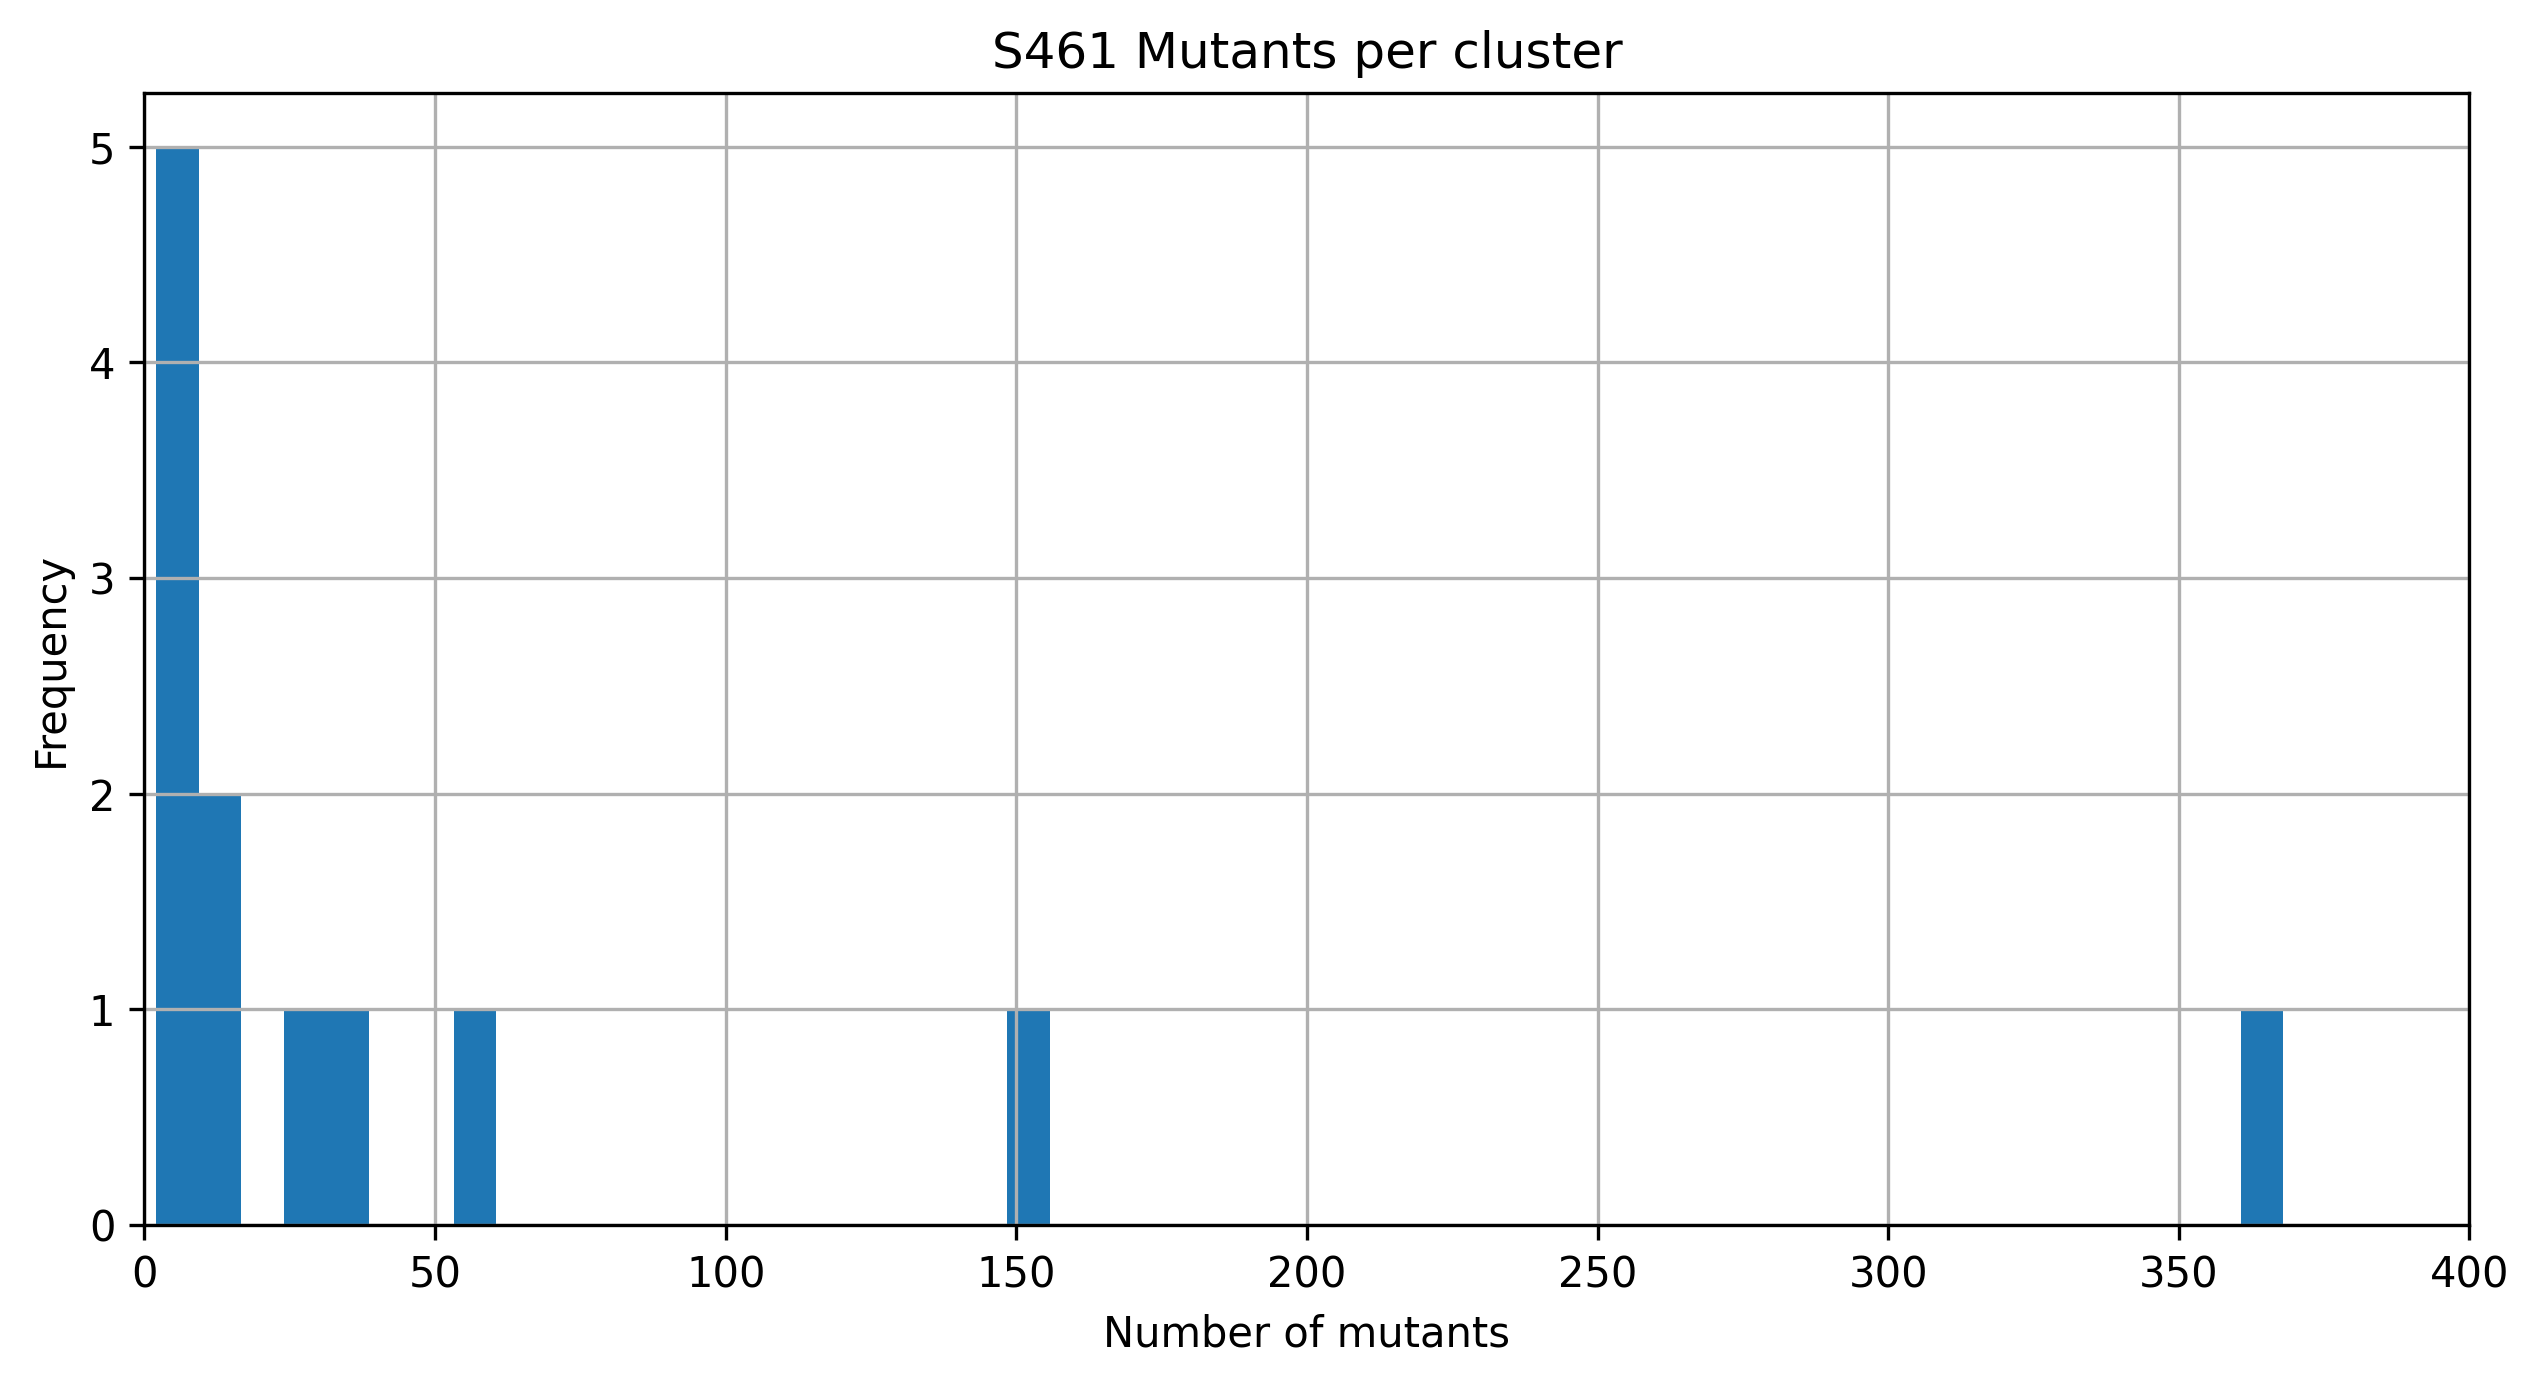

In [8]:
# compile predictions and measurements for statistical analysis
db_class = db_stacked_preds.reset_index().set_index('uid').join(db_ddgs_2).join(db_clusters.reset_index('uid2', drop=True)).reset_index().set_index(['direction', 'uid'])
print('Original unique mutations:', len(db_class))

original_pred_cols = [c for c in db_class.columns if  not 'runtime' in c and not 'pll' in c and not 'ddG' in c and not 'cluster' in c]
original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
#for col in ['esm2_15B_half_dir', 'esm2_150M_dir']:
#    original_pred_cols_reduced.remove(col)
print(original_pred_cols_reduced)

db_class = db_class[original_pred_cols_reduced + ['ddG', 'cluster']]

evolutionary = ['tranception', 'msa_transformer', 'esm1v', 'msa', 'esm2', 'ankh']
structural = ['mpnn', 'mif', 'mifst', 'esmif']
supervised = ['MAESTRO', 'ThermoNet', 'INPS', 'PremPS', 'mCSM', 'DUET', 'ACDC', 'I-Mutant3.0', 'SAAFEC', 'MuPro']
untrained = ['DDGun']
potential = ['KORPM', 'PopMusic', 'SDM']
biophysical = ['cartesian_ddg', 'FoldX', 'Evo']

db_class_rescaled = db_class.copy(deep=True)
db_class_rescaled[original_pred_cols_reduced] /= db_class_rescaled[original_pred_cols_reduced].std()

#db_class['structural'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in structural])]].mean(axis=1)
#db_class['evolutionary'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in evolutionary])]].mean(axis=1)
#db_class['supervised'] = db_class[[c for c in db_class.columns if any([s in c for s in supervised])]].mean(axis=1)
#db_class['potential'] = db_class[[c for c in db_class.columns if any([s in c for s in potential])]].mean(axis=1)
#db_class['biophysical'] = db_class[[c for c in db_class.columns if any([s in c for s in biophysical])]].mean(axis=1)
db_class['mpnn_rosetta'] = db_class['cartesian_ddg'] + db_class['mpnn_20_00']

#db_class['mpnn_mean'] = db_class[['mpnn_10_00', 'mpnn_20_00', 'mpnn_30_00']].mean(axis=1)
#db_runtimes['runtime_mpnn_mean'] = db_runtimes[['runtime_mpnn_10_00', 'runtime_mpnn_20_00', 'runtime_mpnn_30_00']].sum(axis=1)

#db_class['esmif_mean'] = db_class[['esmif_multimer', 'esmif_monomer']].mean(axis=1)
#db_runtimes['runtime_esmif_mean'] = db_runtimes[['runtime_esmif_multimer', 'runtime_esmif_monomer']].sum(axis=1)

#db_class['mif_mean'] = db_class[['mif', 'mifst']].mean(axis=1)
#db_runtimes['runtime_mif_mean'] = db_runtimes[['runtime_mif', 'runtime_mifst']].sum(axis=1)

#db_class['esm2_mean'] = db_class[['esm2_15B_half', 'esm2', 'esm2_650M', 'esm2_150M']].mean(axis=1)
#db_runtimes['runtime_esm2_mean'] = db_runtimes[['runtime_esm2_15B_half', 'runtime_esm2', 'runtime_esm2_650M', 'runtime_esm2_150M']].sum(axis=1)

#db_class['ensemble_dir'] = db_class['cartesian_ddg_dir'] + db_class['mpnn_20_00_dir']
# random (Gaussian noise) control
db_class['random'] = np.random.normal(loc=0, size=len(db_class))
db_class['korpm'] = db_class['KORPM']

#db_class = db_class.reset_index('uid2', drop=True)

print(db_class['cluster'])

fig, axes = plt.subplots(1, figsize=(10, 5), dpi=300) 
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=50, ax=axes)
#db_class.groupby('cluster').count().iloc[:, 0].hist(bins=800, ax=axes[1])
plt.xlim([0,400])
plt.title('S461 Mutants per cluster')
plt.xlabel('Number of mutants')
plt.ylabel('Frequency')

group_counts = db_class.groupby('cluster').count().iloc[:, 0]
print(group_counts)
large_groups = group_counts > 0
filtered_df = db_class[db_class['cluster'].isin(large_groups[large_groups].index)]
db_class = filtered_df

#l1 = len(db_class)
#db_class = db_class.loc[~db_feats_2['on_interface']]
#l2 = len(db_class)
#print(f'Dropped {l1-l2} interface mutations')
#db_class = db_class.loc[~db_feats_2['on_interface']]
#print(f'Dropped {l2-len(db_class)} mutations in binding regions')

print('Unique mutations in chosen set:', len(db_class))
print('Unique clusters (protein families with significant structural homology):', len(db_class['cluster'].unique()))

#db_class.to_csv('../data/Ssym_mapped_preds_clusters_extra.csv')
db_class

In [9]:
db_class.groupby('cluster').count().iloc[:, [1]]

,ACDC-NN-Seq
cluster,
1,28
2,150
3,10
4,8
5,368
6,2
7,6
8,56
9,10


In [10]:
# add the "extras" file which has predictions from the Q3421-trained ensemble
db_class = pd.read_csv('../data/inference/Ssym_mapped_preds_clusters_extra.csv')
db_class = db_class.set_index(['direction', 'uid'])
db_class

,,ACDC-NN,ACDC-NN-Seq,Cartddg,DDG,DDGun,DDGun3D,DUET,Dynamut,Dynamut2,Evo,...,q3421_pslm_rfa_3,q3421_pslm_rfa_4,q3421_pslm_rfa_5,q3421_pslm_rfa_6,q3421_pslm_rfa_7,q3421_pslm_rfa_8,q3421_pslm_rfa_9,q3421_pslm_rfa_10,q3421_pslm_rfa_11,q3421_pslm_rfa_12
direction,uid,,,,,,,,,,,,,,,,,,,,,
dir,1AMQ_191F,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,-1.34,-0.43,...,-0.685152,-0.760084,-0.819829,-0.461518,-0.372427,-0.431428,-0.522017,-0.522017,-0.522017,-0.509859
inv,1AMQ_191F,-0.179437,0.000000,-2.74,1.6,-1.0,-1.0,-1.735,-0.727,-2.07,-0.16,...,0.447325,0.953620,0.751211,0.433907,0.431254,0.560104,0.565154,0.565154,0.565154,0.550818
dir,1AMQ_191S,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,-2.18,-1.18,...,-1.275288,-1.255161,-1.335505,-1.093924,-1.010897,-1.026613,-1.067890,-1.067890,-1.067890,-1.061243
inv,1AMQ_191S,0.150363,0.000000,2.98,1.9,-0.2,0.4,-0.375,1.315,-1.60,0.92,...,0.895602,1.320202,1.111730,1.026075,1.048344,1.132530,1.160249,1.160249,1.160249,1.151314
dir,1AMQ_191W,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,-1.75,0.24,...,-0.711087,-0.866700,-0.892530,-0.527214,-0.430065,-0.504193,-0.667702,-0.667702,-0.667702,-0.655851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
inv,5PTI_35G,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,-0.55,0.81,...,-0.219883,0.549454,0.494859,-0.775876,-0.765323,-0.582487,-0.562655,-0.562655,-0.562655,-0.504172
dir,5PTI_43G,-1.785572,-1.548846,-8.00,-5.7,-2.1,-1.9,-2.580,-1.420,-3.05,-3.00,...,-1.702394,-1.763221,-1.866308,-3.010258,-3.014120,-3.014360,-2.980920,-2.980920,-2.980920,-2.964761
inv,5PTI_43G,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,-0.56,1.96,...,1.508876,1.996893,1.851275,1.778552,1.656090,1.750678,1.809970,1.809970,1.809970,1.814100


In [11]:
importlib.reload(analysis_utils)
# compute statistics on the results for use by later methods
class_result = analysis_utils.compute_stats_bidirectional(db_class, stats=(), grouper='cluster', stacked=True)
#class_result.to_csv(os.path.join(path, 'results', 's461_summary_table.csv'))

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

In [12]:
table1 = class_result #.loc[:,['n', 'MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman']]
table = table1.sort_values(['direction', 'weighted_spearman'], ascending=False).reset_index()

for source, target in remap_names.items():
    table.loc[table['model']==source, 'model'] = target
#table['model'] = table['model'].map(remap_names)
table.loc[table['model'].isin(['Gaussian noise', 'ΔΔG label']), 'model_type'] = 'control'

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'antisymmetry': 'Antisymmetry', 'bias': 'Bias',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'pearson': 'Pearson', 'precision': 'Precision'}
table = table.rename(remap_cols, axis=1)
#table = table[['direction', 'model_type', 'model', 'n', 'MCC', 'AUPRC', 'ρ', 'wNDCG', 'wAUPRC', 'wρ', 'mean_t1s', 'Net Stabilization',
#    'mean_stabilization', 'mean PPC', 'mean MSC', 'True Positives', 'Sensitivity', 'Accuracy', 'Pearson']]
table = table.rename({'direction': 'Direction', 'model_type': 'Model Type', 'model': 'Model'}, axis=1)
table = table[['Direction', 'Model Type', 'Model', 'n', 'Spearman\'s ρ', 'Sensitivity', 'Precision', 'Antisymmetry', 'Bias']]
#table = table.loc[table['model'].isin(['PremPS'])] 
#table = table.loc[table['Model'].isin(['Rosetta CartDDG', 'ProteinMPNN mean', 'ProteinMPNN 30', 'ProteinMPNN 20', 'ESM-IF', 'MIF', 'ESM-IF(M)', 'Ankh', 'MutComputeX',
#    'ESM-2 3B', 'ESM-2 15B', 'ESM-2 150M', 'ESM-2 650M', #'ESM-2 mean', 'ESM-IF mean', 'MIF mean', 'Clustered Ensemble', 'Ensemble 2', 'ESM-1V 2', 'MSA-T 1', 'Structural', 'Evolutionary', 'Supervised'
#    'ProteinMPNN 10', 'MIF-ST', 'KORPM', 'MSA-T mean', 'Tranception', 'ESM-1V mean', 'Stability Oracle', 'Ankh', 'MAESTRO', 'ThermoNet', 'ACDC-NN', 'ACDC-NN-Seq', 'PremPS',
#    'PoPMuSiC', 'SDM', 'FoldX', 'Evo', 'INPS3D', 'INPS-Seq', 'DDGun', 'DDGun3D', 'I-Mutant3.0', 'I-Mutant3.0-Seq', 'SAAFEC-SEQ', 'MUPro', 'mCSM', 'DUET', 'Dynamut2',
#     'Gaussian noise', 'ΔΔG label', 'ProteinMPNN + Rosetta CartDDG'])]
table = table.loc[~table['Model'].str.contains('q3421')]
table = table.dropna(subset='Model').set_index(['Direction', 'Model Type', 'Model']).astype(float).round(3).drop_duplicates()

table.xs('combined').sort_values('Spearman\'s ρ', ascending=False)

n  Spearman's ρ  Sensitivity  Precision  \
Model Type   Model                                                           
control      ΔΔG label         684.0         1.000        1.000      1.000   
NaN          DDG               684.0         0.968        0.953      0.976   
supervised   PremPS            684.0         0.839        0.845      0.814   
ensemble     Rosetta/ProtMPNN  684.0         0.744        0.646      0.888   
potential    KORPM             684.0         0.715        0.772      0.786   
ensemble     Ensemble 2 Feats  684.0         0.711        0.722      0.832   
             Ensemble 4 Feats  684.0         0.708        0.784      0.781   
             Ensemble 5 Feats  684.0         0.702        0.754      0.772   
structural   ProteinMPNN 0.3   684.0         0.696        0.731      0.806   
             ProteinMPNN mean  684.0         0.693        0.690      0.828   
             ProteinMPNN 0.2   684.0         0.690        0.690      0.828   
ensemble     Ensemble 3 Feats  684.0         0.686        0.708      0.826   
NaN          biophysical       684.0         0.685        0.635      0.844   
             Structural        684.0         0.673        0.646      0.819   
biophysical  Rosetta CartDDG   684.0         0.665        0.614      0.827   
structural   ProteinMPNN 0.1   684.0         0.648        0.640      0.820   
NaN          Cartddg           684.0         0.628        0.579      0.825   
structural   MIF mean          684.0         0.626        0.620      0.774   
NaN          Supervised        684.0         0.625        0.418      0.861   
transfer     ACDC-NN           684.0         0.620        0.699      0.701   
evolutionary MSA-T mean        684.0         0.611        0.734      0.734   
             MSA-T median      684.0         0.608        0.746      0.746   
NaN          potential         684.0         0.606        0.684      0.791   
transfer     Stability Oracle  683.0         0.606        0.619      0.844   
structural   MIF-ST            684.0         0.604        0.675      0.755   
evolutionary ESM-2 15B         684.0         0.600        0.737      0.737   
NaN          Evolutionary      684.0         0.592        0.737      0.737   
structural   MIF               684.0         0.591        0.564      0.788   
evolutionary ESM-2 mean        684.0         0.588        0.737      0.737   
             ESM-2 650M        684.0         0.585        0.728      0.728   
             Ankh              684.0         0.579        0.725      0.725   
             Tranception       684.0         0.575        0.731      0.731   
             ESM-2 3B          684.0         0.574        0.734      0.734   
transfer     ACDC-NN-Seq       684.0         0.568        0.576      0.694   
structural   ESM-IF mean       684.0         0.553        0.558      0.758   
             ESM-IF(M)         684.0         0.553        0.558      0.758   
             ESM-IF            684.0         0.552        0.558      0.755   
untrained    DDGun3D           684.0         0.547        0.646      0.695   
             DDGun             684.0         0.542        0.649      0.679   
supervised   INPS-Seq          684.0         0.542        0.646      0.654   
biophysical  FoldX             684.0         0.514        0.602      0.720   
             Evo               684.0         0.480        0.611      0.672   
potential    PoPMuSiC          684.0         0.471        0.275      0.832   
structural   MutComputeX       684.0         0.470        0.427      0.874   
supervised   INPS3D            684.0         0.460        0.371      0.770   
ensemble     Dynamut           684.0         0.454        0.681      0.687   
evolutionary ESM-1V mean       684.0         0.454        0.664      0.664   
             ESM-1V median     684.0         0.451        0.661      0.661   
             ESM-2 150M        684.0         0.450        0.673      0.673   
supervised   ThermoNet         678.0         0.415       

In [13]:
db_class_ = db_class.copy(deep=True)
new_index = db_class_.reset_index()
new_index = new_index['uid'] + '_' + new_index['direction']
db_class_.index = new_index
db_class_.columns = [c+'_dir' for c in db_class_.columns]
db_class_ = db_class_.rename({'cluster_dir': 'cluster'}, axis=1)
db_class_['ddG'] = db_class_['ddG_dir']
db_class_['code'] = db_class_.index.str[:4]
db_class_

,ACDC-NN_dir,ACDC-NN-Seq_dir,Cartddg_dir,DDG_dir,DDGun_dir,DDGun3D_dir,DUET_dir,Dynamut_dir,Dynamut2_dir,Evo_dir,...,q3421_pslm_rfa_5_dir,q3421_pslm_rfa_6_dir,q3421_pslm_rfa_7_dir,q3421_pslm_rfa_8_dir,q3421_pslm_rfa_9_dir,q3421_pslm_rfa_10_dir,q3421_pslm_rfa_11_dir,q3421_pslm_rfa_12_dir,ddG,code
1AMQ_191F_dir,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,-1.34,-0.43,...,-0.819829,-0.461518,-0.372427,-0.431428,-0.522017,-0.522017,-0.522017,-0.509859,-1.6,1AMQ
1AMQ_191F_inv,-0.179437,0.000000,-2.74,1.6,-1.0,-1.0,-1.735,-0.727,-2.07,-0.16,...,0.751211,0.433907,0.431254,0.560104,0.565154,0.565154,0.565154,0.550818,1.6,1AMQ
1AMQ_191S_dir,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,-2.18,-1.18,...,-1.335505,-1.093924,-1.010897,-1.026613,-1.067890,-1.067890,-1.067890,-1.061243,-1.9,1AMQ
1AMQ_191S_inv,0.150363,0.000000,2.98,1.9,-0.2,0.4,-0.375,1.315,-1.60,0.92,...,1.111730,1.026075,1.048344,1.132530,1.160249,1.160249,1.160249,1.151314,1.9,1AMQ
1AMQ_191W_dir,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,-1.75,0.24,...,-0.892530,-0.527214,-0.430065,-0.504193,-0.667702,-0.667702,-0.667702,-0.655851,-3.9,1AMQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5PTI_35G_inv,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,-0.55,0.81,...,0.494859,-0.775876,-0.765323,-0.582487,-0.562655,-0.562655,-0.562655,-0.504172,5.0,5PTI
5PTI_43G_dir,-1.785572,-1.548846,-8.00,-5.7,-2.1,-1.9,-2.580,-1.420,-3.05,-3.00,...,-1.866308,-3.010258,-3.014120,-3.014360,-2.980920,-2.980920,-2.980920,-2.964761,-5.7,5PTI
5PTI_43G_inv,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,-0.56,1.96,...,1.851275,1.778552,1.656090,1.750678,1.809970,1.809970,1.809970,1.814100,5.7,5PTI
5PTI_45A_dir,-3.439780,-3.219905,-8.00,-6.9,-5.3,-4.4,-3.734,-3.474,-3.22,-3.35,...,-2.714051,-3.656690,-3.662842,-3.779706,-3.747476,-3.747476,-3.747476,-3.754566,-6.9,5PTI


In [14]:
summ = analysis_utils.compute_stats(db_class_.drop('code', axis=1), 
                                    stats=('n', 'MCC', 'pred_positives', 'tp', 'auprc', 'spearman', 'ndcg', 'mean_t1s', 'mean_stabilization', 'net_stabilization', 'sensitivity', 'recall@k0.0', 'recall@k1.0', 'mean_reciprocal_rank', 'fractional_gain', 'precision'), 
                                    measurements=['ddG'], grouper='cluster', n_classes=2, n_bootstraps=100, quiet=True)
tmp1 = summ.reset_index()

In [15]:
importlib.reload(analysis_utils)
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = summ.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin([c+'_dir' for c in original_pred_cols_reduced] + [
            'random_dir', 
            'ddG_dir', 
            'q3421_pslm_rfa_2_dir', 
            'q3421_pslm_rfa_3_dir', 
            'q3421_pslm_rfa_4_dir',
            'q3421_pslm_rfa_5_dir',
            'mpnn_rosetta_dir'])
            ].drop('measurement', axis=1)
s4 = s3[['model_type', 'model',
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std', 
    'spearman_mean', 'spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6.drop_duplicates()

,Model Type,Model,Recall @ k,NDCG,Spearman's ρ,AUPRC,MCC,Net Stabilization
0,unknown,ΔΔG label,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,769.696 ± 543.32
1,NaN,DDG,0.911 ± 0.05,0.993 ± 0.01,0.956 ± 0.04,0.968 ± 0.03,0.925 ± 0.04,751.87 ± 534.96
2,supervised,PremPS,0.773 ± 0.03,0.929 ± 0.01,0.841 ± 0.06,0.914 ± 0.02,0.663 ± 0.06,656.069 ± 481.49
3,evolutionary,MSA-T median,0.565 ± 0.11,0.847 ± 0.04,0.544 ± 0.22,0.745 ± 0.08,0.456 ± 0.14,569.595 ± 500.37
4,evolutionary,MSA-T mean,0.567 ± 0.11,0.848 ± 0.04,0.544 ± 0.22,0.743 ± 0.08,0.439 ± 0.14,566.238 ± 495.62
5,evolutionary,Ankh,0.537 ± 0.14,0.792 ± 0.07,0.486 ± 0.24,0.7 ± 0.09,0.423 ± 0.15,558.22 ± 496.22
6,ensemble,Ensemble 4 Feats,0.586 ± 0.07,0.869 ± 0.04,0.646 ± 0.14,0.829 ± 0.06,0.525 ± 0.12,556.146 ± 483.69
7,potential,KORPM,0.561 ± 0.08,0.829 ± 0.04,0.661 ± 0.11,0.847 ± 0.04,0.545 ± 0.07,556.14 ± 472.93
9,structural,ProteinMPNN 0.3,0.636 ± 0.06,0.844 ± 0.06,0.616 ± 0.16,0.814 ± 0.08,0.528 ± 0.09,548.513 ± 476.59
10,evolutionary,Tranception,0.546 ± 0.11,0.808 ± 0.07,0.489 ± 0.24,0.707 ± 0.09,0.425 ± 0.16,547.388 ± 508.33


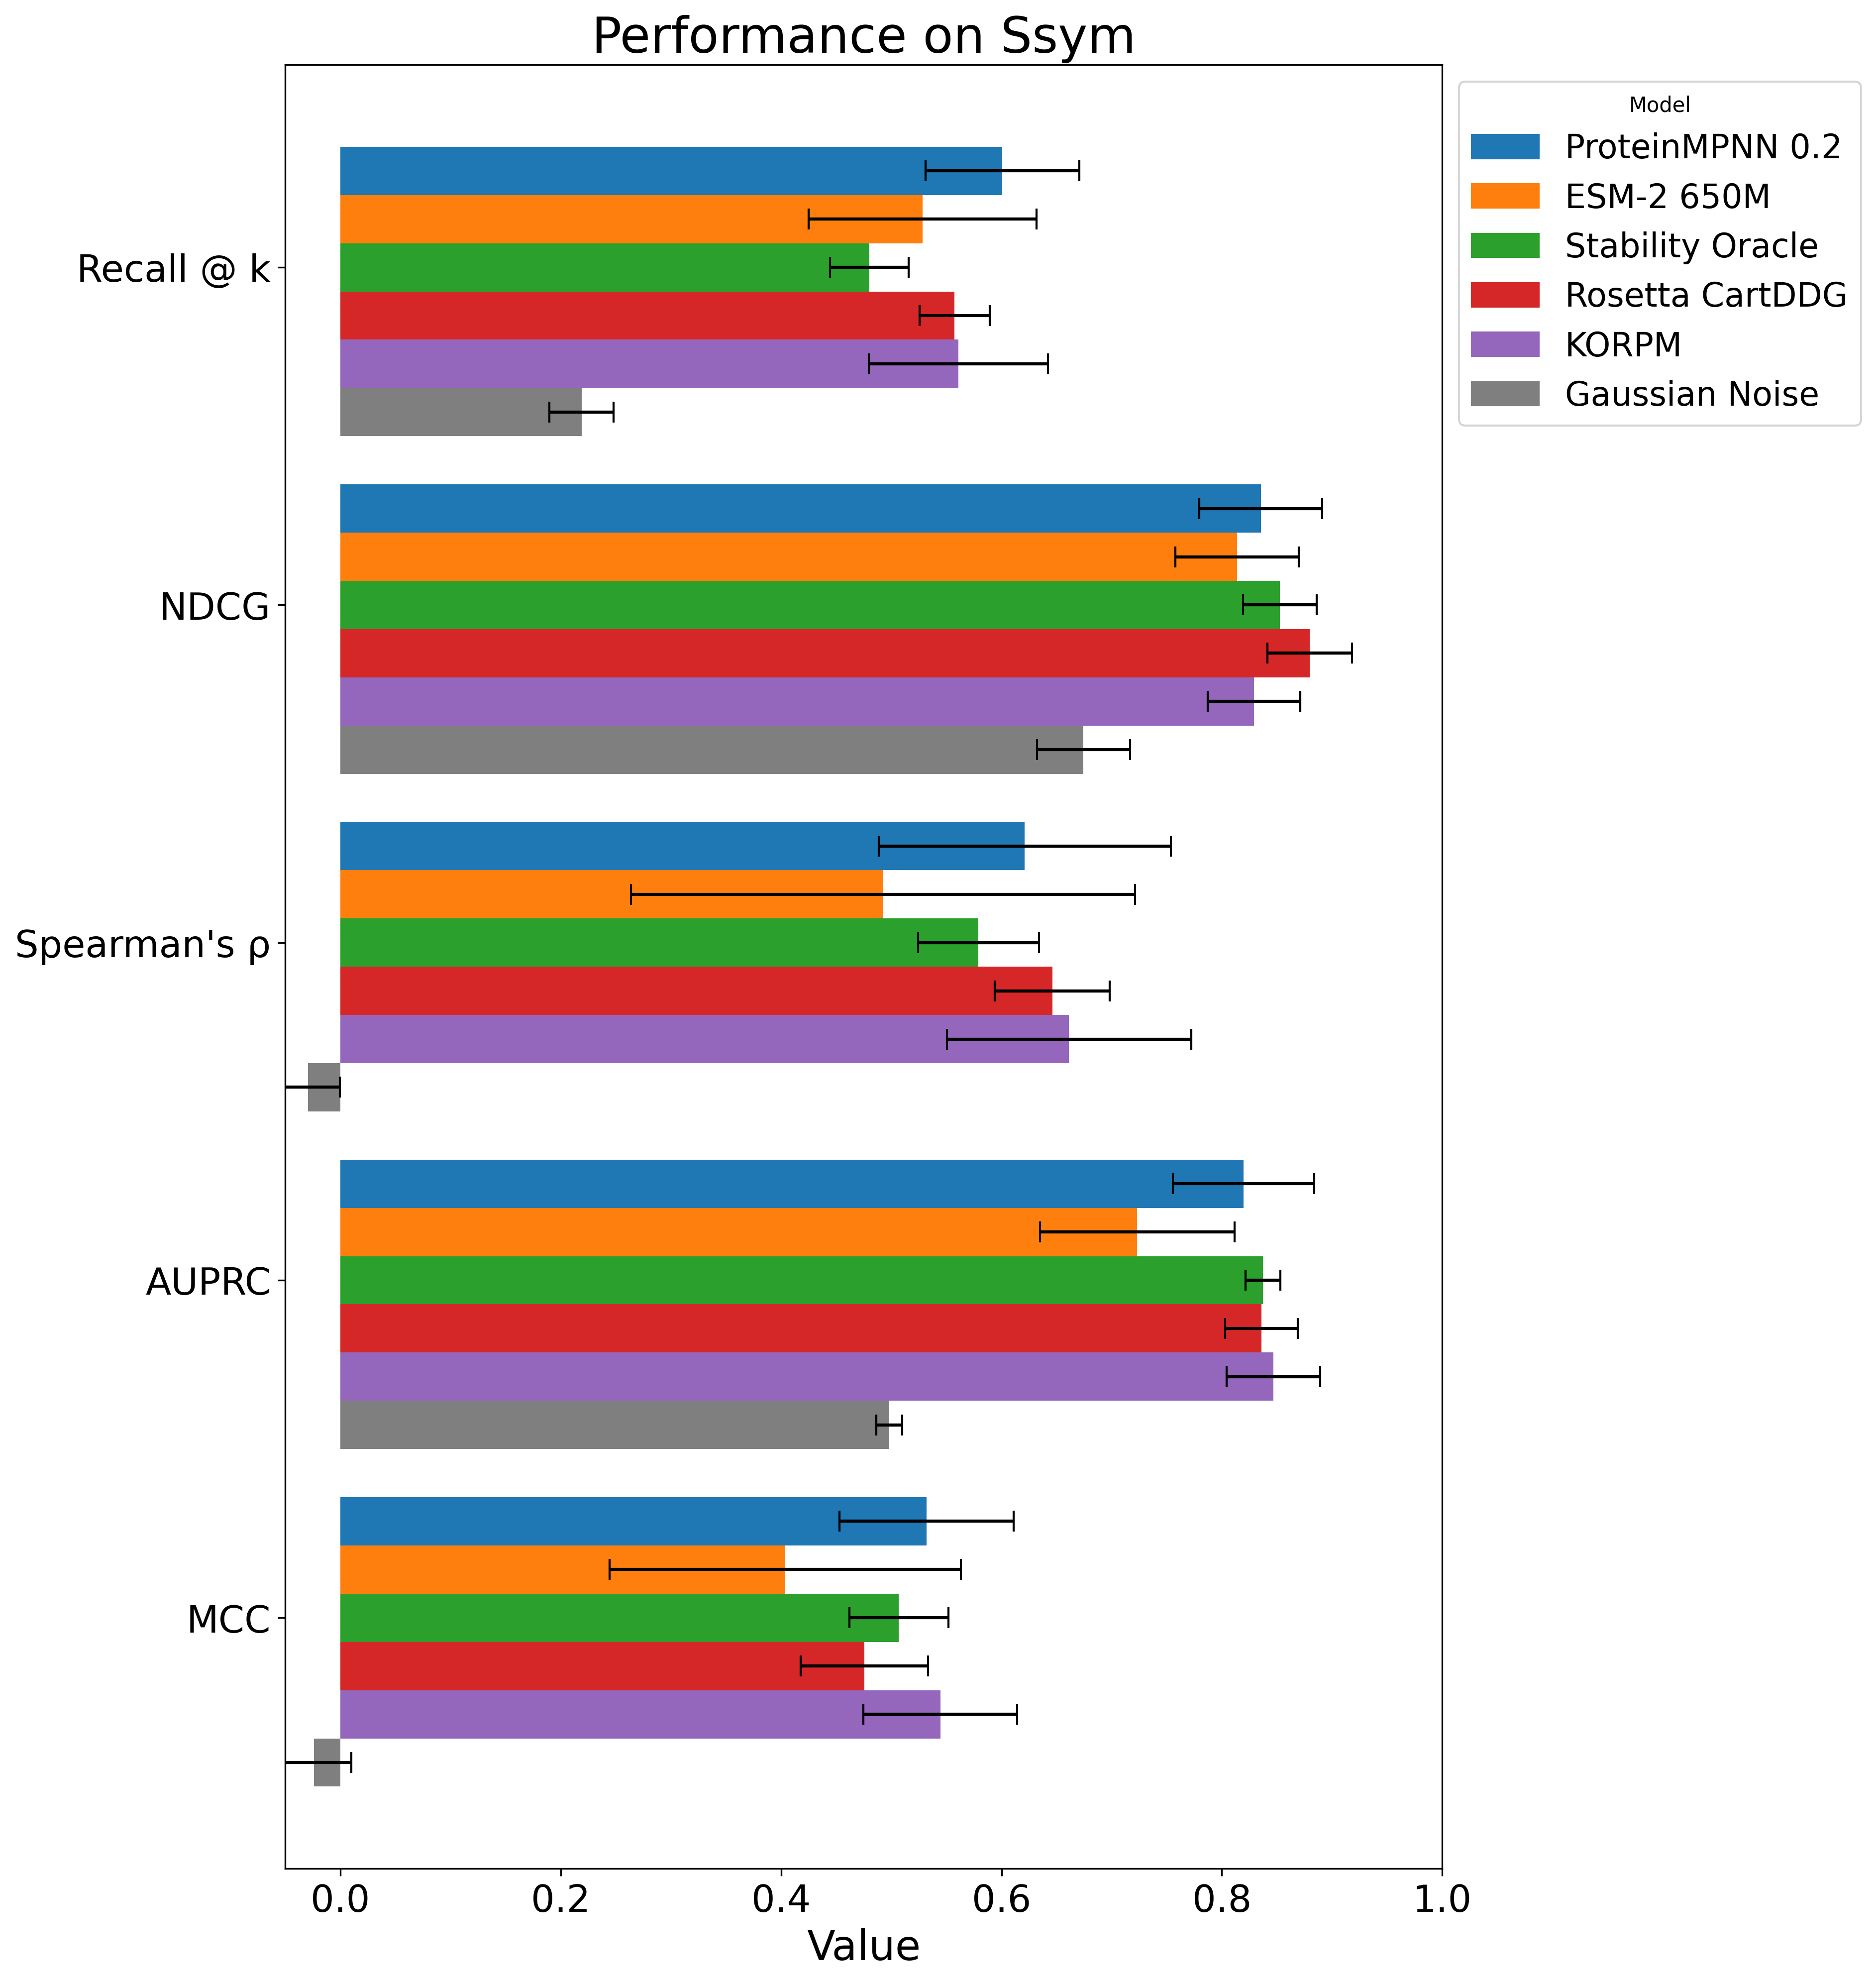

In [16]:
import importlib
importlib.reload(analysis_utils)

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

tmp3 = tmp1.copy(deep=True)#.set_index('model')
#tmp3['fractional_gain_mean'] = tmp3['net_stabilization_mean'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3['fractional_gain_std'] = tmp3['net_stabilization_std'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3 = tmp3.reset_index()
#tmp3['fractional_gain_mean']

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp3.sort_values('spearman_mean', ascending=False).dropna(how='all', axis=1).reset_index()

s4 = s2.loc[s2['model'].isin([c+'_dir' for c in original_pred_cols_reduced] + ['random_dir', 'ddG_dir', 'mpnn_rosetta_dir'])]
#s4 = s3[['model', 'n_mean', 'MCC_mean', 'MCC_std', 'auprc_mean', 'auprc_std', 'spearman_mean', 'spearman_std', 'weighted_ndcg_mean', 'weighted_ndcg_std', 'recall@k1.0_mean', 'recall@k1.0_std', 'mean_stabilization_mean', 'mean_stabilization_std']]
#s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4

tmp2 = s5[[ 'model',  
            'MCC_mean', 'MCC_std',
            'auprc_mean', 'auprc_std',
            #'weighted_spearman_mean', 'weighted_spearman_std',
            'spearman_mean', 'spearman_std',
            #'weighted_ndcg_mean', 'weighted_ndcg_std',
            'ndcg_mean', 'ndcg_std',
            'recall@k1.0_mean', 'recall@k1.0_std', 
            ]].set_index('model')

tmp2.columns = [new_remap_cols[c] for c in tmp2.columns]
tmp2 = tmp2.reset_index().drop_duplicates()

#analysis_utils.make_bar_chart(tmp2, models=['ProteinMPNN 0.2', 'ESM-2 650M', 'Stability Oracle', 'Rosetta CartDDG', 'KORPM', 'DDGun3D', 'MAESTRO', 'Gaussian Noise'], title='Q3421', xlim=(-0.5, 0.8), figsize=(24, 16))
analysis_utils.make_bar_chart(tmp2, models=['mpnn_20_00', 'esm2_650M', 'stability-oracle', 'cartesian_ddg', 'KORPM', 'random'], title='Ssym', xlim=(-0.05, 1), figsize=(10, 16))

In [17]:
zs_feats = ['delta_kdh', 'delta_vol', 'rel_ASA']
#red_cols = [c[:-4] for c in original_pred_cols_reduced]

#models = original_pred_cols_reduced + [c + '_dir' for c in zs_feats]
#models += [c.replace('_dir', '_inv') for c in models]
#print(models)
models = list(db_class.columns)

db_ens = db_class.copy(deep=True)
db_ens = db_ens[models]

print(len(db_ens))
db_ens['random'] = np.random.rand(len(db_ens)) - 0.5
#db_ens['random_inv'] = np.random.rand(len(db_ens)) - 0.5
#db_ens = db_ens.drop(['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir', 'TNetD_dir', 'ACDCNND_dir'], axis=1)
dfm = db_ens.copy(deep=True)

def unstack_frames(df):
    df_dir = df.xs('dir')
    df_dir.columns = [c + '_dir' for c in df_dir.columns]
    df_inv = df.xs('inv')
    df_inv.columns = [c + '_inv' for c in df_inv.columns]
    return df_dir.join(df_inv)
dfu = unstack_frames(dfm)

weights = [1, 0.5, 0.2]
#weights2 = [0.8, 0.3]

all_cols = []

tmp = []
for model1 in models:
    for model2 in models:
        if model1 != model2: #(model1.split('_')[0] != model2.split('_')[0]) and (model1[:4] != model2[:4]) and
            for weight in weights:
                tmp.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #for model3 in models:
                #    if model2 != model3 and model1 != model3:
                #        for weight2 in weights2:
                #            tmp.append(pd.Series(dfm[model1] + dfm[model2] * weight + dfm[model3] * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                #            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')

dfm = pd.concat([dfm] + tmp, axis=1)
#dfm = dfm.join(db_stacked_runtimes)
dfm
#dfm.to_csv(os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_preds.csv'))
#dfm

684


,,ACDC-NN,ACDC-NN-Seq,Cartddg,DDG,DDGun,DDGun3D,DUET,Dynamut,Dynamut2,Evo,...,q3421_pslm_rfa_12 + q3421_pslm_rfa_8 * 0.2,q3421_pslm_rfa_12 + q3421_pslm_rfa_9 * 1,q3421_pslm_rfa_12 + q3421_pslm_rfa_9 * 0.5,q3421_pslm_rfa_12 + q3421_pslm_rfa_9 * 0.2,q3421_pslm_rfa_12 + q3421_pslm_rfa_10 * 1,q3421_pslm_rfa_12 + q3421_pslm_rfa_10 * 0.5,q3421_pslm_rfa_12 + q3421_pslm_rfa_10 * 0.2,q3421_pslm_rfa_12 + q3421_pslm_rfa_11 * 1,q3421_pslm_rfa_12 + q3421_pslm_rfa_11 * 0.5,q3421_pslm_rfa_12 + q3421_pslm_rfa_11 * 0.2
direction,uid,,,,,,,,,,,,,,,,,,,,,
dir,1AMQ_191F,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,-1.34,-0.43,...,-0.491733,-0.851933,-0.636087,-0.506579,-0.851933,-0.636087,-0.506579,-0.851933,-0.636087,-0.506579
inv,1AMQ_191F,-0.179437,0.000000,-2.74,1.6,-1.0,-1.0,-1.735,-0.727,-2.07,-0.16,...,0.546815,0.921365,0.687683,0.547473,0.921365,0.687683,0.547473,0.921365,0.687683,0.547473
dir,1AMQ_191S,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,-2.18,-1.18,...,-1.044827,-1.757820,-1.316263,-1.051329,-1.757820,-1.316263,-1.051329,-1.757820,-1.316263,-1.051329
inv,1AMQ_191S,0.150363,0.000000,2.98,1.9,-0.2,0.4,-0.375,1.315,-1.60,0.92,...,1.136618,1.908437,1.428691,1.140843,1.908437,1.428691,1.140843,1.908437,1.428691,1.140843
dir,1AMQ_191W,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,-1.75,0.24,...,-0.624121,-1.092741,-0.816656,-0.651005,-1.092741,-0.816656,-0.651005,-1.092741,-0.816656,-0.651005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
inv,5PTI_35G,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,-0.55,0.81,...,-0.512077,-0.880852,-0.648202,-0.508612,-0.880852,-0.648202,-0.508612,-0.880852,-0.648202,-0.508612
dir,5PTI_43G,-1.785572,-1.548846,-8.00,-5.7,-2.1,-1.9,-2.580,-1.420,-3.05,-3.00,...,-2.943150,-4.908771,-3.676205,-2.936665,-4.908771,-3.676205,-2.936665,-4.908771,-3.676205,-2.936665
inv,5PTI_43G,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,-0.56,1.96,...,1.785338,2.992024,2.243628,1.794590,2.992024,2.243628,1.794590,2.992024,2.243628,1.794590


In [18]:
def get_summary_df(db_complete, cols=None, saveloc=os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_results.csv'), stats=(), stacked=False):

    assert os.path.exists(os.path.dirname(saveloc))
    #assert not os.path.exists(saveloc)
    #if cols is None:
    #    cols = db_complete.columns.drop(['code'])#, 'ddG_dir', 'ddG_inv'])

    if not stacked:
        db_stacked = analysis_utils.stack_frames(db_complete)
    else:
        db_stacked = db_complete
    #db_stacked['code'] = list(db_stacked.reset_index()['uid'].str[:4])
    #print(db_stacked)

    df_summ = analysis_utils.compute_stats_bidirectional(db_stacked, stacked=True, stats=(), grouper='cluster', directions=['dir', 'inv']).reset_index().set_index(['direction', 'model'])#.join(df_reg) #.drop('n_total', axis=1))
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1).set_index(['direction', 'model_type', 'model', 'class'])
    df_summ = df_summ.sort_index(level=1).sort_index(level=0)#.drop_duplicates()
    df_summ.to_csv(saveloc)
    return df_summ

In [19]:
# takes a long time to compute and has already been done
#d1 = get_summary_df(dfm, saveloc=os.path.join(path, 'data', 'pairwise', 'pairwise_ssym_combinations_3_weights.csv'), stats=(), stacked=True) 

d1 = pd.read_csv(os.path.join(path, 'data', 'pairwise', 'pairwise_ssym_combinations_3_weights.csv')).set_index(['direction', 'model_type', 'model', 'class'])

In [20]:
dfu_ = dfu.join(db_stacked_runtimes)
dfu_

ACDC-NN_dir  ACDC-NN-Seq_dir  Cartddg_dir  DDG_dir  \
direction uid                                                             
dir       1AMQ_191F     0.155387         0.000000        -8.00     -1.6   
          1AMQ_191S    -0.310174         0.000000        -4.22     -1.9   
          1AMQ_191W     0.175478         0.000235        -8.00     -3.9   
          1AMQ_191Y     0.255306         0.007419        -7.80     -2.3   
          1BNI_14A     -1.032232        -1.280774        -8.00     -4.5   
...                          ...              ...          ...      ...   
inv       5PTI_22A     -1.802440        -1.794489        -6.23     -1.2   
          5PTI_23A     -3.107841        -2.997760        -8.00     -5.9   
          5PTI_35G     -3.815977        -3.124952        -8.00     -5.0   
          5PTI_43G     -1.785572        -1.548846        -8.00     -5.7   
          5PTI_45A     -3.439780        -3.219905        -8.00     -6.9   

                     DDGun_dir  DDGun3D_dir  DUET_dir  Dynamut_dir  \
direction uid                                                        
dir       1AMQ_191F        0.9          0.9    -0.992        0.800   
          1AMQ_191S        0.2         -0.5    -1.717       -0.149   
          1AMQ_191W        1.1          1.0    -1.495        1.222   
          1AMQ_191Y        1.3          1.3    -1.307        1.210   
          1BNI_14A        -3.1         -3.1    -3.172       -2.526   
...                        ...          ...       ...          ...   
inv       5PTI_22A        -2.6         -2.5    -3.573       -1.876   
          5PTI_23A        -4.2         -4.0    -3.980       -3.729   
          5PTI_35G        -4.5         -4.4    -4.156       -3.250   
          5PTI_43G        -2.1         -1.9    -2.580       -1.420   
          5PTI_45A        -5.3         -4.4    -3.734       -3.474   

                     Dynamut2_dir  Evo_dir  ...  runtime_mpnn_20_00  \
direction uid                               ...                       
dir       1AMQ_191F         -1.34    -0.43  ...            0.016232   
          1AMQ_191S         -2.18    -1.18  ...            0.014761   
          1AMQ_191W         -1.75     0.24  ...            0.014751   
          1AMQ_191Y         -1.23    -3.15  ...            0.015225   
          1BNI_14A          -2.34    -2.93  ...            0.008188   
...                           ...      ...  ...                 ...   
inv       5PTI_22A          -3.01    -3.13  ...            0.008387   
          5PTI_23A          -3.86    -3.57  ...            0.007620   
          5PTI_35G          -3.94    -4.04  ...            0.007639   
          5PTI_43G          -3.05    -3.00  ...            0.008101   
          5PTI_45A          -3.22    -3.35  ...            0.007606   

                     runtime_mpnn_30_00  runtime_msa_1  runtime_msa_2  \
direction uid                                                           
dir       1AMQ_191F            0.016989       3.390493       3.497325   
          1AMQ_191S            0.016065       3.393482       3.394148   
          1AMQ_191W            0.016062       3.393750       3.387580   
          1AMQ_191Y            0.016026       3.397354       3.391266   
          1BNI_14A             0.008603       1.350701       1.348936   
...                                 ...            ...            ...   
inv       5PTI_22A             0.007817       0.882186       0.882716   
          5PTI_23A             0.007565       1.026886       0.895081   
          5PTI_35G             0.007818       0.881158       0.881511   
          5PTI_43G             0.008260       0.881816       0.880770   
          5PTI_45A             0.007539       0.881755       0.881217   

                     runtime_msa_3  runtime_msa_4  runtime_msa_5  \
direction uid                                                      
dir       1AMQ_191F       3.481303       3.485137       3.457739   
          1AMQ_191S       3.398332       3.395951       

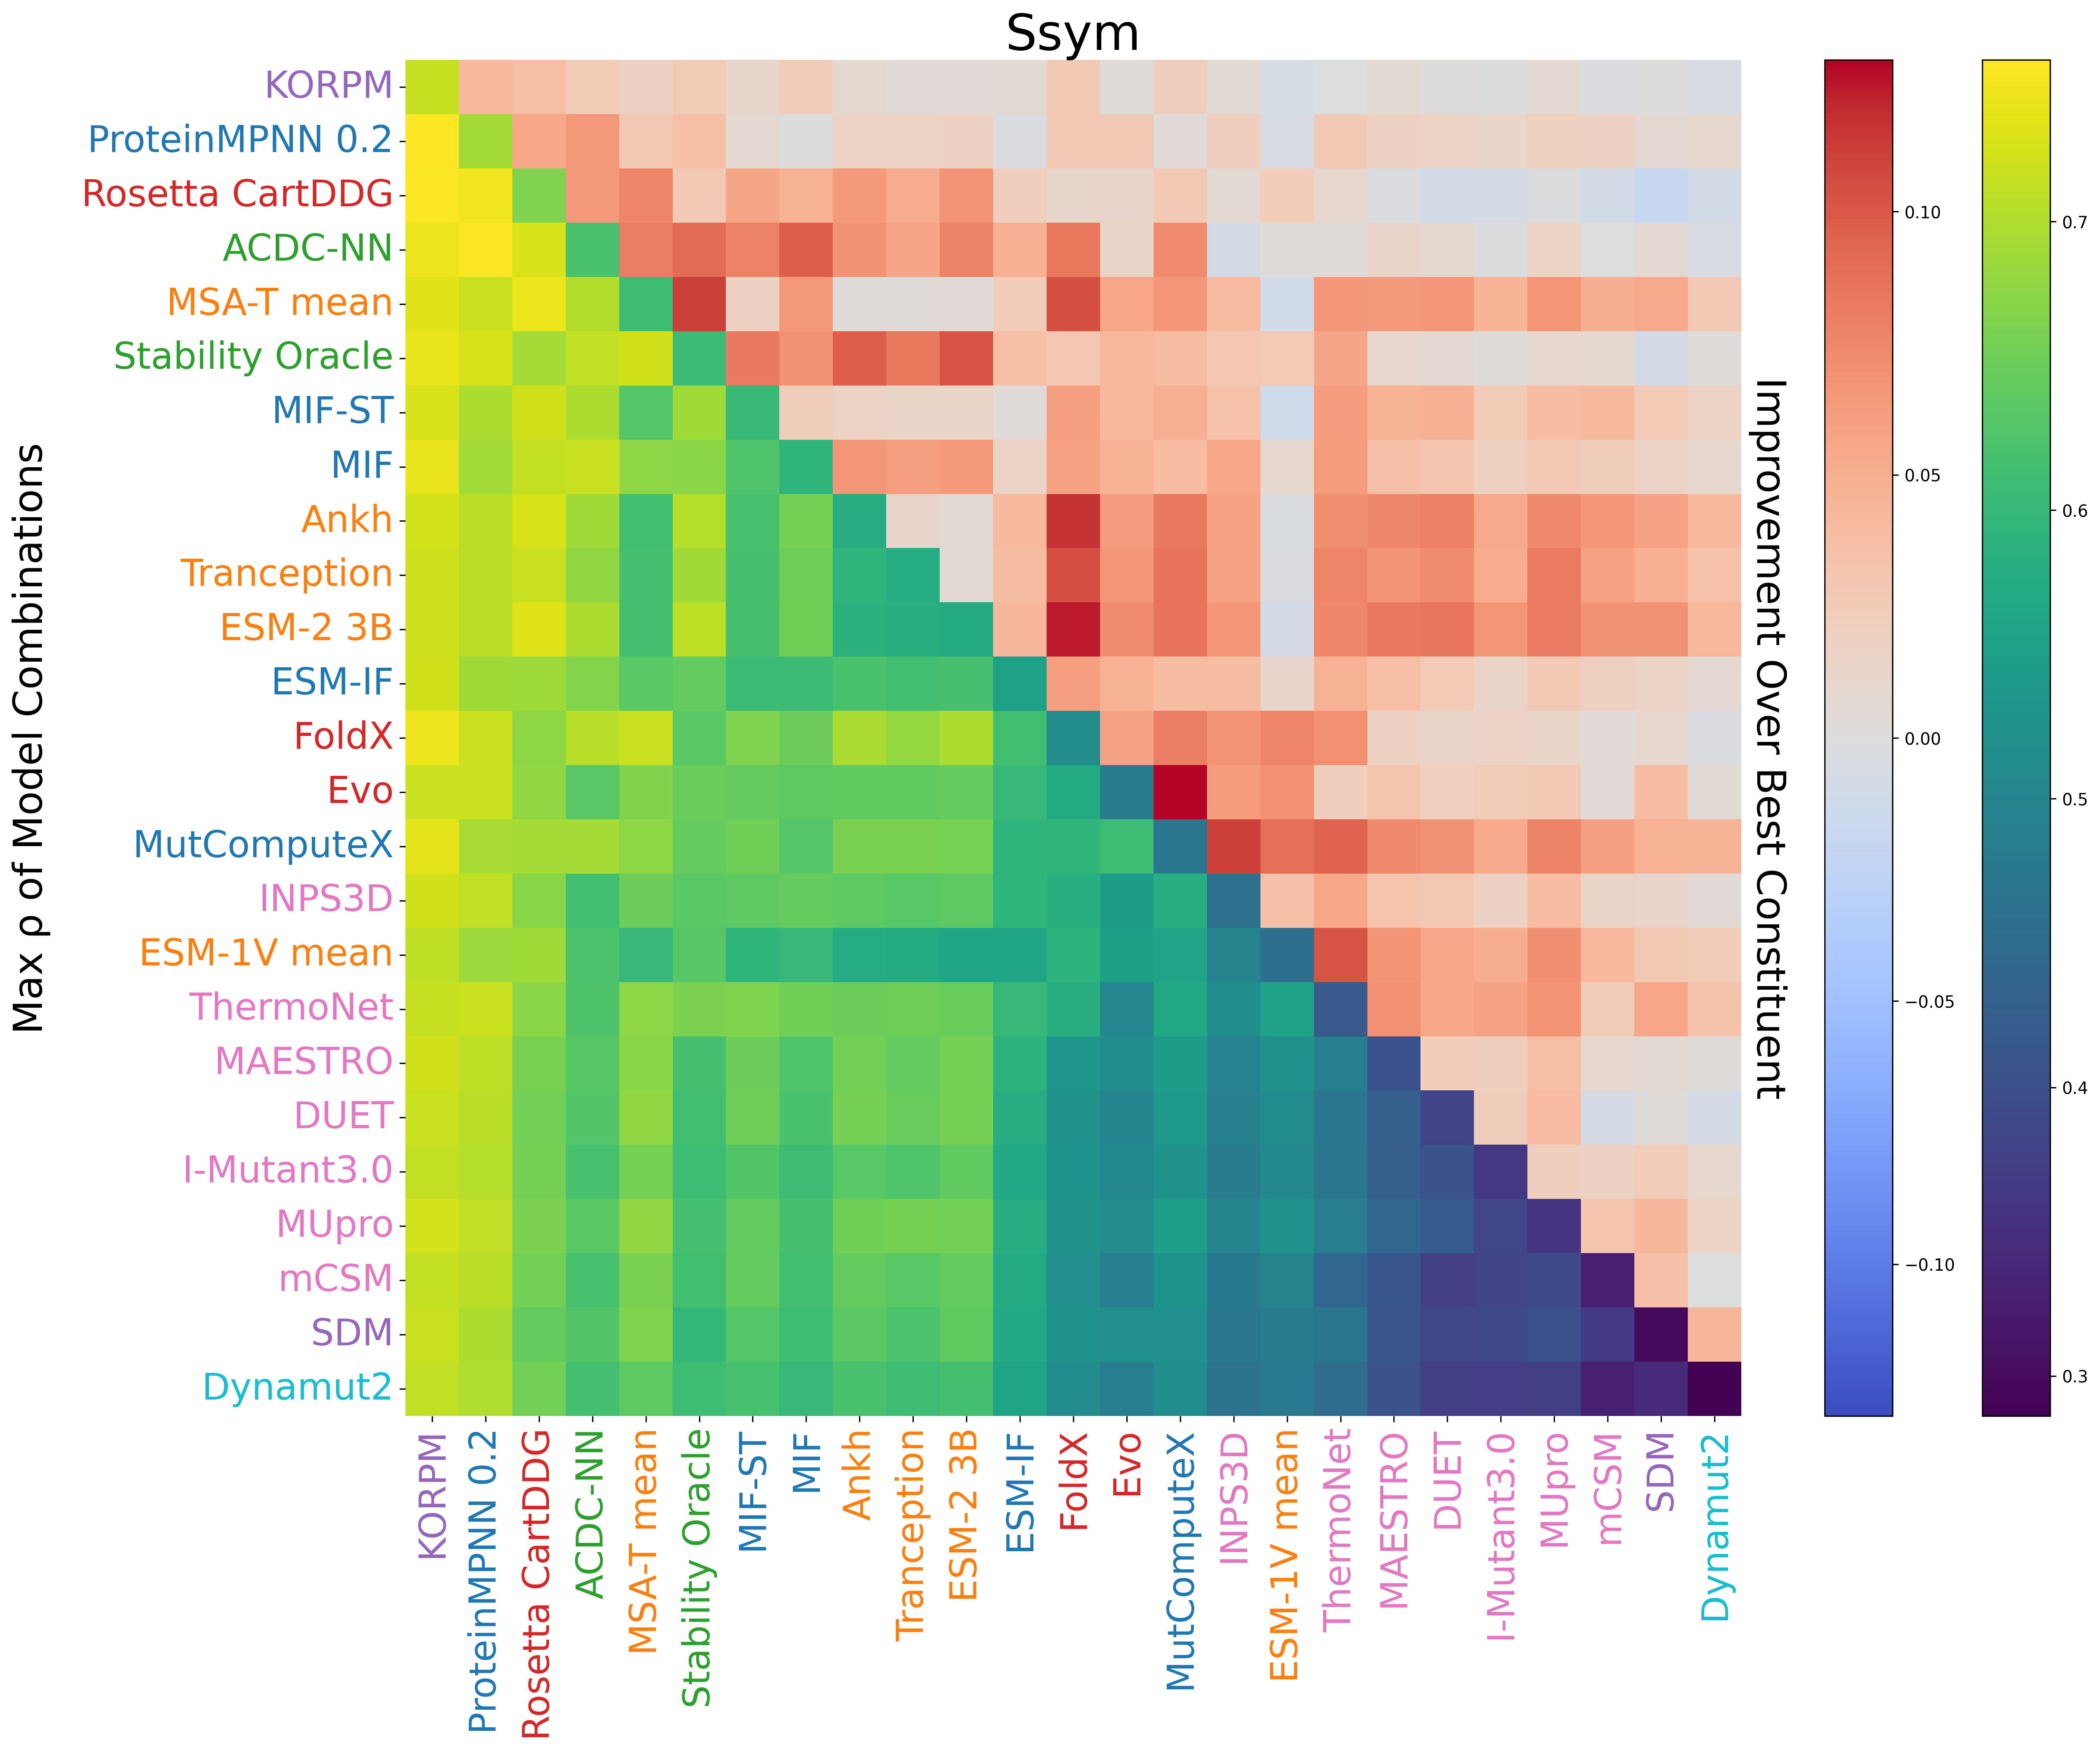

{'esm2', 'Evo', 'ThermoNet', 'tranception', 'stability-oracle', 'INPS3D', 'mifst', 'cartesian_ddg', 'KORPM', 'ACDC-NN', 'FoldX', 'mutcomputex', 'ankh', 'MUpro', 'MAESTRO', 'mif', 'esmif_multimer', 'msa_transformer_mean', 'mpnn_20_00'}


,model1,weight1,model2,weight2,spearman,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,KORPM,1.0,mpnn_20_00,0.5,0.755972,0.714950,1.0259,6.108144
2,ACDC-NN,1.0,mpnn_20_00,1.0,0.755558,0.584479,-0.0001,6.108144
3,KORPM,1.0,cartesian_ddg,1.0,0.753333,0.662762,216509.0259,-0.000100
4,cartesian_ddg,1.0,mpnn_20_00,1.0,0.745455,0.634668,216507.9999,6.108144
5,KORPM,1.0,FoldX,0.5,0.743656,0.450146,1.0259,-0.000100
...,...,...,...,...,...,...,...,...
321,Dynamut2,1.0,SDM,1.0,0.342694,0.425244,-0.0001,-0.000100
322,mCSM,1.0,mCSM,0.0,0.328077,1.000000,-0.0001,-0.000100
323,mCSM,1.0,Dynamut2,0.2,0.327839,0.816947,-0.0001,-0.000100


In [21]:
subset = [#'ACDC-NN-Seq', 
        'ACDC-NN', 
        'DDGun'
        'DDGun3D',
        'DUET',
        'Dynamut2',
        'FoldX',
        'Evo',
        'I-Mutant3.0',
        #'I-Mutant3.0-Seq',
        #'INPS-Seq',
        'INPS3D',
        'MAESTRO',
        'MUpro',
        'PopMusic',
        #'PremPS',
        'ThermoNet',
        'SAAFEC-Seq',
        'SDM',
        #'SOL_ACC',
        #'delta_kdh',
        #'delta_vol',
        #'abs_ASA',
        'ThermoNet',
        'mCSM',
        'cartesian_ddg',
        'esm1v_mean',
        #'esm2_mean',
        'esm2',
        'ankh',
        'msa_transformer_mean',
        'tranception',
        #'esmif_monomer',
        'esmif_multimer',
        'KORPM',
        'mpnn_20_00',
        'mif',
        'mifst',
        #'mpnn_mean',
        #'esmif_mean',
        #'mif_mean',
        'stability-oracle',
        'mutcomputex']

direction = 'combined'
statistic = 'spearman'
upper = 'delta'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfu_, statistic, direction, upper, subset=subset, annot=False, title='Ssym')
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
stat_df

In [22]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
stat_df_.to_csv('../data/stat_df_ssym.csv')
stat_df_

,Rank,Base model,Added Model,Weight,Spearman's rho,Model Correlation,CPU time (s),GPU time (s)
0,1,KORPM,ProteinMPNN 0.2,0.5,0.76,0.71,1.03,6.11
1,2,ACDC-NN,ProteinMPNN 0.2,1.0,0.76,0.58,-0.00,6.11
2,3,KORPM,Rosetta CartDDG,1.0,0.75,0.66,216509.03,-0.00
3,4,Rosetta CartDDG,ProteinMPNN 0.2,1.0,0.75,0.63,216508.00,6.11
4,5,KORPM,FoldX,0.5,0.74,0.45,1.03,-0.00
...,...,...,...,...,...,...,...,...
320,321,Dynamut2,SDM,1.0,0.34,0.43,-0.00,-0.00
321,322,mCSM,mCSM,0.0,0.33,1.00,-0.00,-0.00
322,323,mCSM,Dynamut2,0.2,0.33,0.82,-0.00,-0.00
323,324,SDM,SDM,0.0,0.30,1.00,-0.00,-0.00


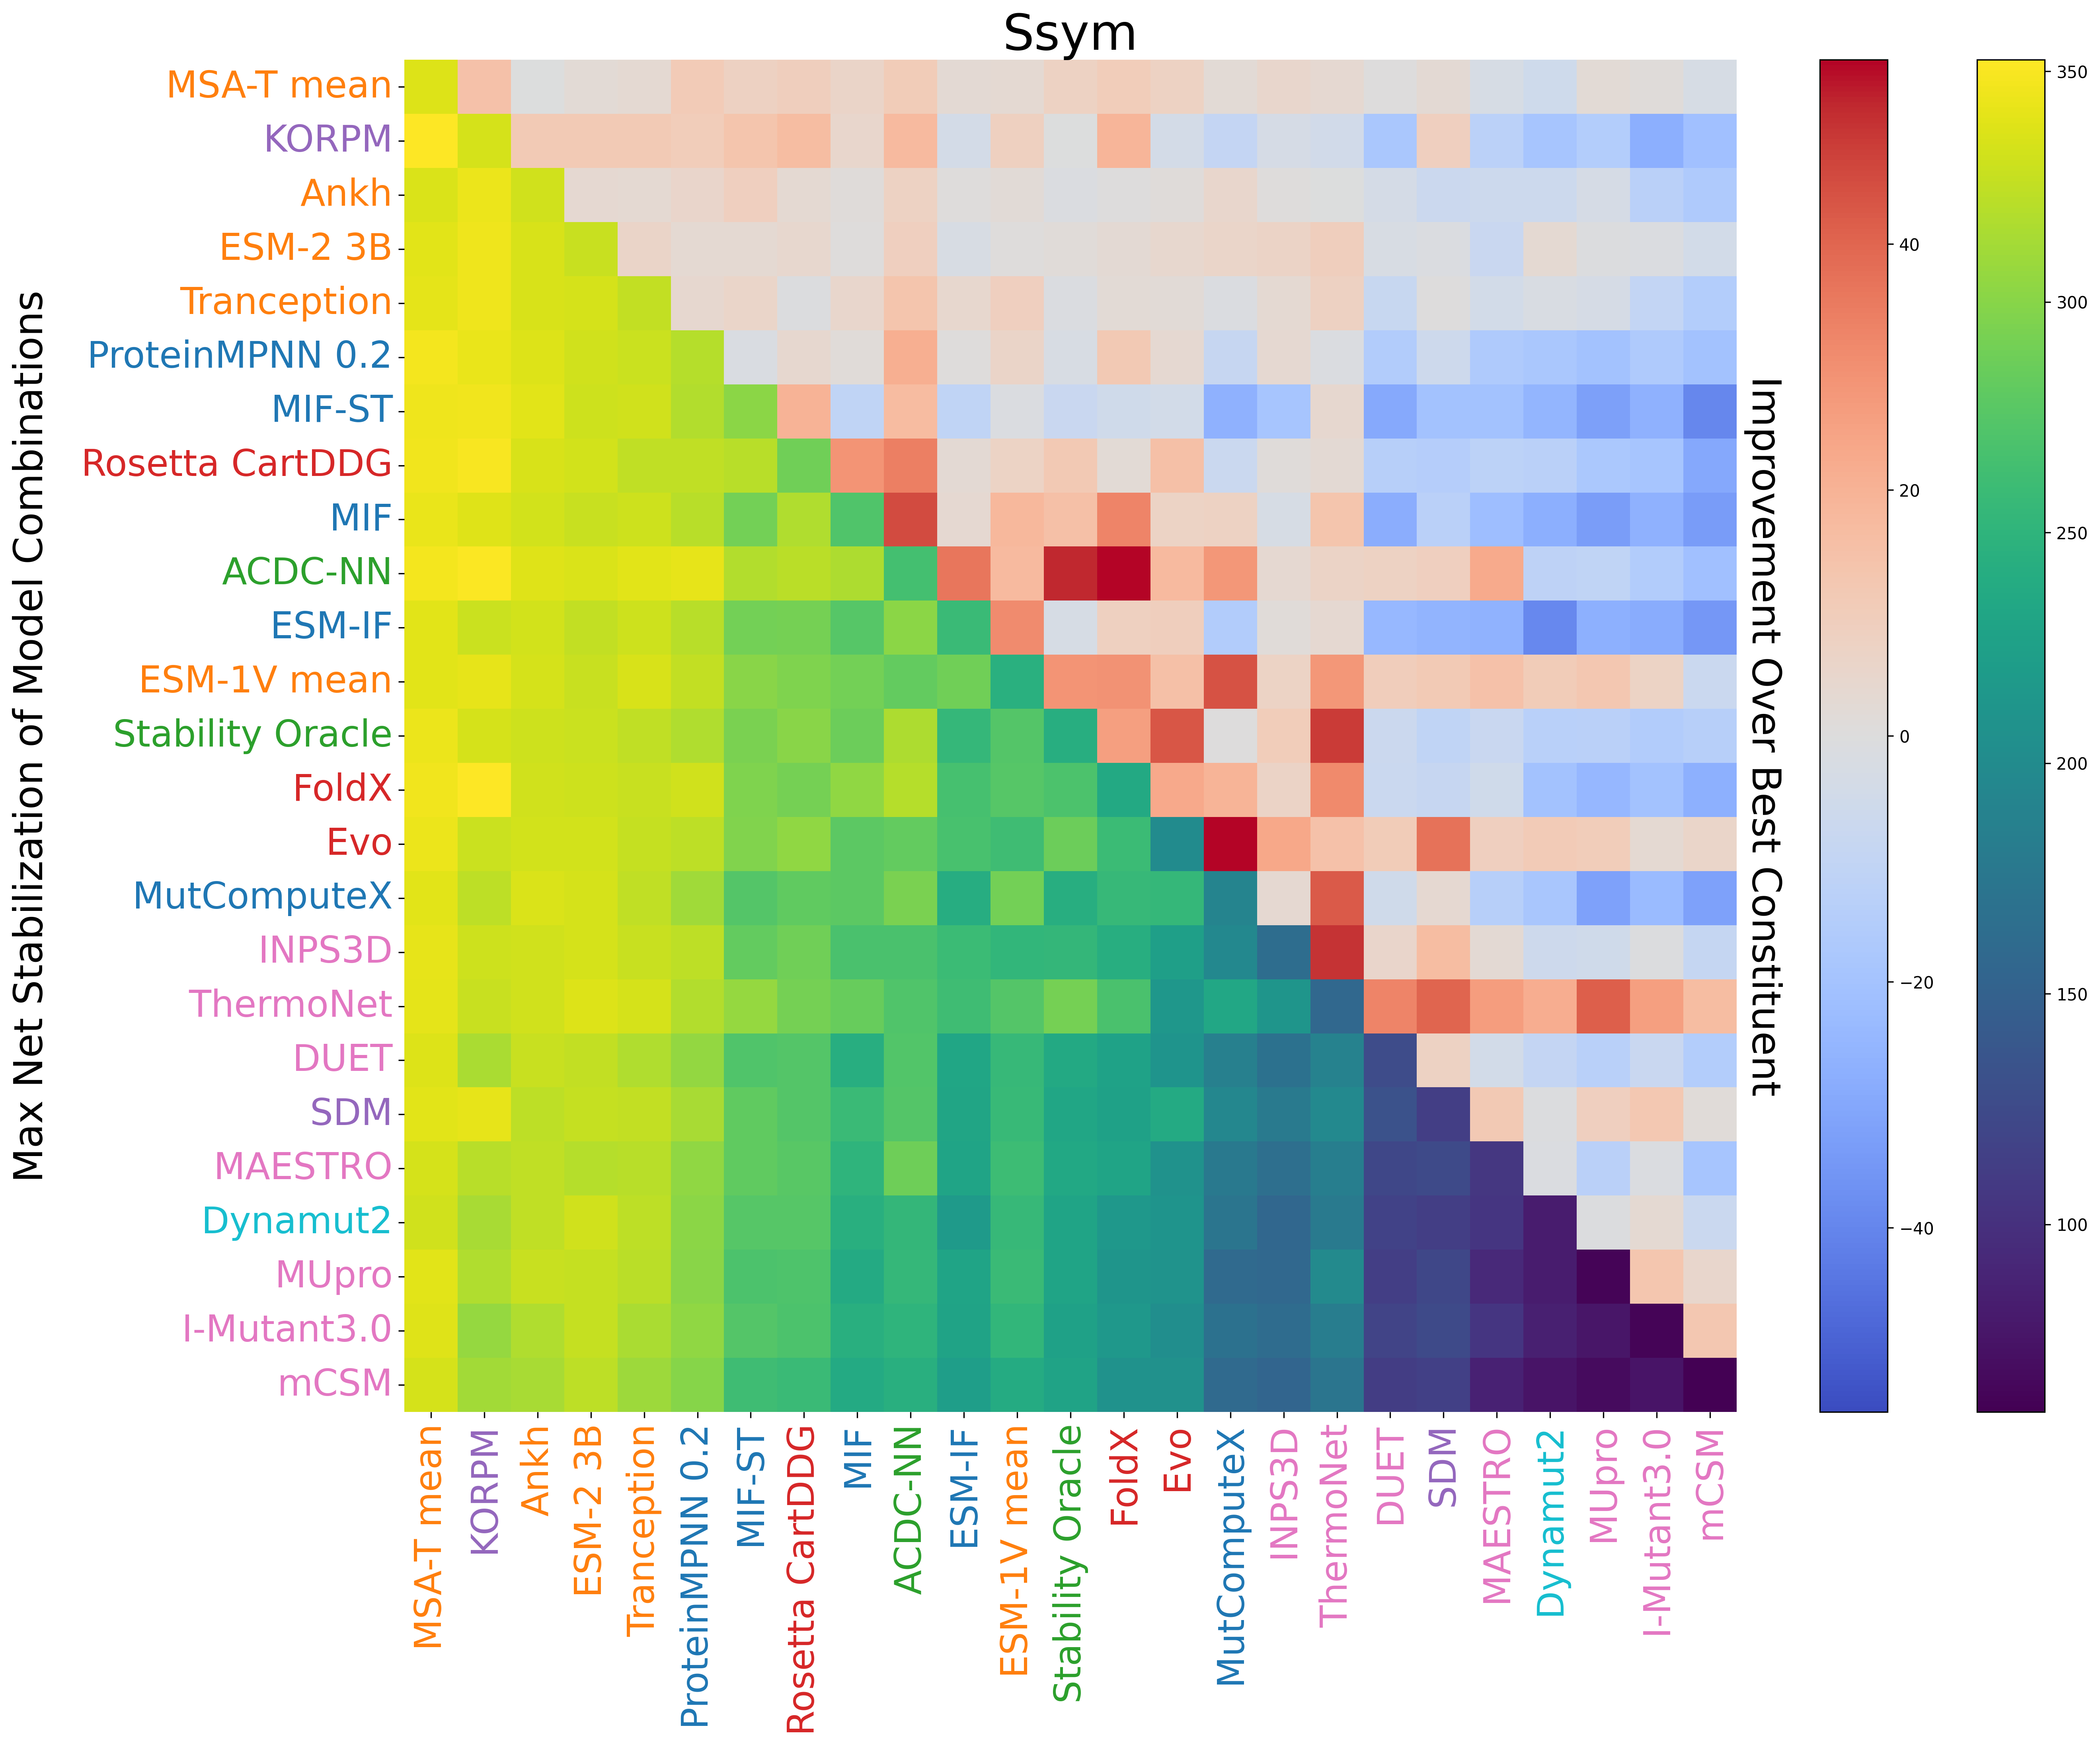

{'esm2', 'Evo', 'ThermoNet', 'tranception', 'stability-oracle', 'INPS3D', 'mifst', 'cartesian_ddg', 'KORPM', 'ACDC-NN', 'FoldX', 'ankh', 'mutcomputex', 'MUpro', 'esm1v_mean', 'mif', 'SDM', 'esmif_multimer', 'msa_transformer_mean', 'mpnn_20_00'}


,model1,weight1,model2,weight2,net_stabilization,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,KORPM,1.0,FoldX,0.5,352.481,0.450146,1.0259,-0.000100
2,KORPM,1.0,msa_transformer_mean,0.2,351.551,0.660584,1.0259,4874.611195
3,KORPM,1.0,ACDC-NN,0.2,350.403,0.684548,1.0259,-0.000100
4,KORPM,1.0,cartesian_ddg,0.5,349.913,0.662762,216509.0259,-0.000100
5,msa_transformer_mean,1.0,mpnn_20_00,0.5,347.661,0.658826,-0.0001,4880.719440
...,...,...,...,...,...,...,...,...
319,Dynamut2,1.0,mCSM,0.2,74.399,0.816947,-0.0001,-0.000100
320,MUpro,1.0,mCSM,0.5,67.629,0.529011,-0.0001,-0.000100
321,MUpro,1.0,MUpro,0.0,62.590,1.000000,-0.0001,-0.000100


In [23]:
importlib.reload(analysis_utils)

subset = [#'ACDC-NN-Seq', 
        'ACDC-NN', 
        'DDGun'
        'DDGun3D',
        'DUET',
        'Dynamut2',
        'FoldX',
        'Evo',
        'I-Mutant3.0',
        #'I-Mutant3.0-Seq',
        #'INPS-Seq',
        'INPS3D',
        'MAESTRO',
        'MUpro',
        'PopMusic',
        #'PremPS',
        'ThermoNet',
        'SAAFEC-Seq',
        'SDM',
        #'SOL_ACC',
        #'delta_kdh',
        #'delta_vol',
        #'abs_ASA',
        'ThermoNet',
        'mCSM',
        'cartesian_ddg',
        'esm1v_mean',
        #'esm2_mean',
        'esm2',
        'ankh',
        'msa_transformer_mean',
        'tranception',
        #'esmif_monomer',
        'esmif_multimer',
        'KORPM',
        'mpnn_20_00',
        'mif',
        'mifst',
        #'mpnn_mean',
        #'esmif_mean',
        #'mif_mean',
        'stability-oracle',
        'mutcomputex']

direction = 'combined'
statistic = 'net_stabilization'
upper = 'delta'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfu_, statistic, direction, upper, subset=subset, annot=False, title='Ssym')
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
stat_df

In [24]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
stat_df_.to_csv('../data/stat_df_net_stab_ssym.csv')
stat_df_

,Rank,Base model,Added Model,Weight,net_stabilization,Model Correlation,CPU time (s),GPU time (s)
0,1,KORPM,FoldX,0.5,352.48,0.45,1.03,-0.00
1,2,KORPM,MSA-T mean,0.2,351.55,0.66,1.03,4874.61
2,3,KORPM,ACDC-NN,0.2,350.40,0.68,1.03,-0.00
3,4,KORPM,Rosetta CartDDG,0.5,349.91,0.66,216509.03,-0.00
4,5,MSA-T mean,ProteinMPNN 0.2,0.5,347.66,0.66,-0.00,4880.72
...,...,...,...,...,...,...,...,...
318,319,Dynamut2,mCSM,0.2,74.40,0.82,-0.00,-0.00
319,320,MUpro,mCSM,0.5,67.63,0.53,-0.00,-0.00
320,321,MUpro,MUpro,0.0,62.59,1.00,-0.00,-0.00
321,322,I-Mutant3.0,I-Mutant3.0,0.0,62.43,1.00,-0.00,-0.00


In [25]:
supp = d1.xs('dir')[['auprc', 'mean_stabilization', 'net_stabilization', 'weighted_ndcg', 'weighted_spearman', 'auppc', 'aumsc', 'antisymmetry', 'bias']].reset_index().drop(['model_type', 'class'], axis=1)#.set_index('model')
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='dir')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)
df_merged = df_merged.loc[(df_merged['model1']!='ddG')&(df_merged['model1']!='PremPS')]

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

23


,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization
312,I-Mutant3.0-Seq,ACDC-NN,0.5,0.839316,0.067922,24.040
89,I-Mutant3.0-Seq,Rosetta CartDDG,0.5,0.838720,0.063948,30.151
311,I-Mutant3.0-Seq,mCSM,0.5,0.837299,0.059304,21.049
171,I-Mutant3.0-Seq,SDM,0.2,0.836452,0.059729,21.231
287,I-Mutant3.0-Seq,DUET,0.2,0.836365,0.060566,27.740
222,I-Mutant3.0-Seq,KORPM,0.2,0.836054,0.067433,23.100
17,I-Mutant3.0-Seq,Dynamut,0.2,0.835989,0.060843,18.981
264,I-Mutant3.0-Seq,ProteinMPNN 0.2,0.2,0.835319,0.060978,24.941
307,I-Mutant3.0-Seq,INPS3D,0.5,0.834490,0.067659,25.001
88,I-Mutant3.0,Rosetta CartDDG,1.0,0.833567,0.061043,32.481


In [26]:
supp = d1.xs('combined')[['auprc', 'weighted_ndcg', 'weighted_spearman', 'mean_stabilization', 'net_stabilization', 'auppc', 'aumsc']].reset_index().drop(['model_type', 'class'], axis=1)
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)
df_merged = df_merged.loc[(df_merged['model1']!='ddG')&(df_merged['model1']!='PremPS')]

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

26


,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization
224,KORPM,MAESTRO,0.5,0.896518,0.447761,320.571
54,FoldX,MSA-T mean,0.5,0.886000,0.449631,346.589
82,Rosetta CartDDG,KORPM,0.5,0.884911,0.454668,349.913
77,Rosetta CartDDG,MSA-T mean,0.2,0.881138,0.459898,345.781
329,DDGun3D,MAESTRO,0.5,0.880485,0.429935,237.352
91,Rosetta CartDDG,MAESTRO,0.5,0.880379,0.425786,276.083
328,DDGun,MAESTRO,0.5,0.880253,0.436462,251.351
84,Rosetta CartDDG,MIF-ST,0.2,0.880185,0.449933,321.463
90,Rosetta CartDDG,INPS3D,0.2,0.879292,0.436617,289.412
72,ACDC-NN,FoldX,0.5,0.878050,0.451317,320.161


In [27]:
rand = class_result.reset_index()
rand = rand.loc[rand['model'].str.contains('random')]
rand['model'] = 'random'
rand['model_type'] = np.nan
rand = rand.set_index(['direction', 'model_type', 'model'])
dr = pd.concat([d1.reset_index(), rand.reset_index()])
dr = dr.set_index(['direction', 'model_type', 'model'])

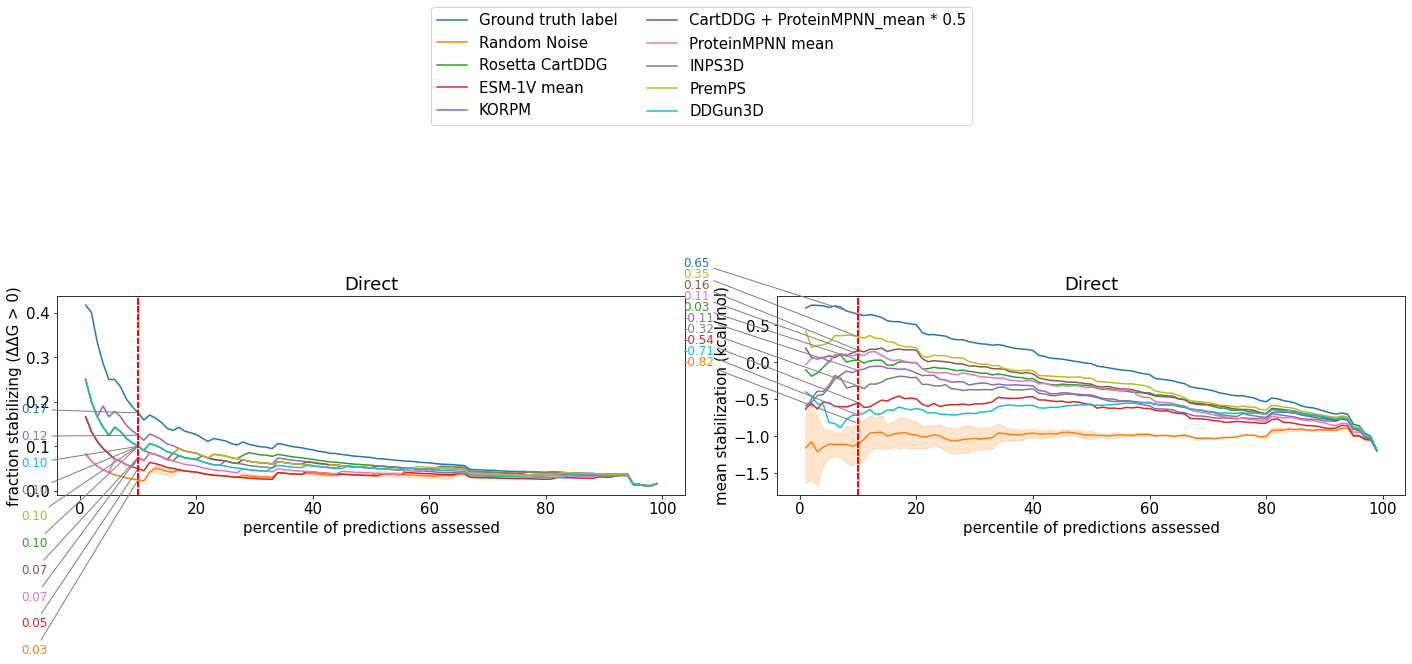

In [31]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'esm1v_mean', 'PremPS', 'korpm', 'DDGun3D', 'INPS3D', 'ddG', 'random'], percentile_labels=[10], directions=['dir'])

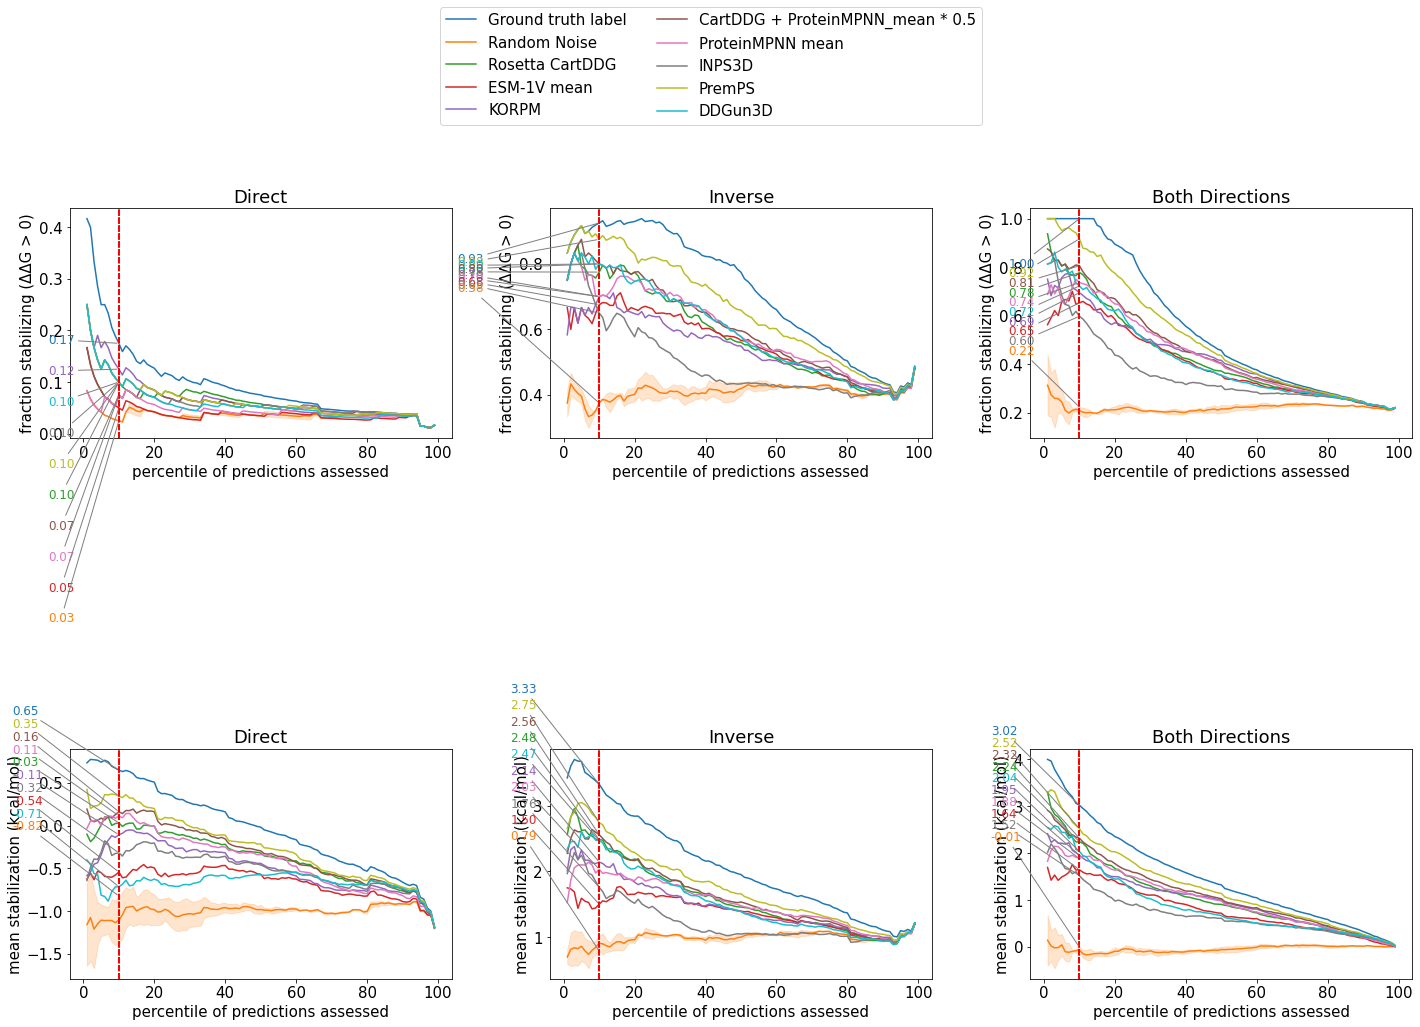

In [32]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'esm1v_mean', 'PremPS', 'korpm', 'DDGun3D', 'INPS3D', 'ddG', 'random'], directions=['dir', 'inv'], percentile_labels=[10])

In [30]:
pd.concat([dr.xs('dir').sort_values('90%', ascending=False).head(10)[['90%', '90$', 'net_stabilization']], dr.xs('dir').sort_values('90$', ascending=False).head(10).tail(9)[['90%', '90$', 'net_stabilization']]])

90%       90$  \
model_type   model                                                    
NaN          random                              0.037931 -0.918072   
supervised   INPS-Seq + mifst * 1                0.037931 -0.756038   
             INPS-Seq + mifst * 0.2              0.037931 -0.751521   
             INPS-Seq + mif_mean * 1             0.037931 -0.768417   
             INPS-Seq + mif_mean * 0.5           0.037931 -0.752555   
             INPS-Seq + mif_mean * 0.2           0.037931 -0.749797   
             INPS-Seq + mif * 1                  0.037931 -0.744969   
             INPS-Seq + mif * 0.5                0.037931 -0.752555   
             INPS-Seq + mif * 0.2                0.037931 -0.752210   
             INPS-Seq + mCSM * 0.2               0.037931 -0.760486   
evolutionary ddG + msa_transformer_median * 0.2  0.037931 -0.660176   
NaN          cluster + ddG * 0.2                 0.037931 -0.660176   
             ddG + cluster * 1                   0.037931 -0.660176   
             ddG + cluster * 0.5                 0.037931 -0.660176   
             ddG + cluster * 0.2                 0.037931 -0.660176   
supervised   ddG + SAAFEC-SEQ * 0.2              0.037931 -0.660176   
             ddG + MUpro * 0.2                   0.037931 -0.660176   
NaN          ddG + DDG * 0.5                     0.037931 -0.660176   
             ddG + DDG * 0.2                     0.037931 -0.660176   

                                                 net_stabilization  
model_type   model                                                  
NaN          random                                       -188.052  
supervised   INPS-Seq + mifst * 1                           -5.639  
             INPS-Seq + mifst * 0.2                        -26.349  
             INPS-Seq + mif_mean * 1                         0.761  
             INPS-Seq + mif_mean * 0.5                       5.261  
             INPS-Seq + mif_mean * 0.2                     -23.649  
             INPS-Seq + mif * 1                              6.591  
             INPS-Seq + mif * 0.5                            4.611  
             INPS-Seq + mif * 0.2                          -21.719  
             INPS-Seq + mCSM * 0.2                         -16.550  
evolutionary ddG + msa_transformer_median * 0.2             54.749  
NaN          cluster + ddG * 0.2                          -321.941  
             ddG + cluster * 1                            -140.191  
             ddG + cluster * 0.5                           -26.711  
             ddG + cluster * 0.2                            37.579  
supervised   ddG + SAAFEC-SEQ * 0.2                         54.400  
             ddG + MUpro * 0.2                              56.700  
NaN          ddG + DDG * 0.5                                56.341  
             ddG + DDG * 0.2                                57.461